## Dependencies

In [1]:
import numpy as np
import pandas as pd

import pickle

import plotly.express as px
import plotly.offline as pyo
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

from tqdm import trange, tqdm
import tqdm.notebook as tq

import warnings
warnings.filterwarnings("ignore")

### Note: All the dependencies can be installed using 'pip'

## Datasets

In [3]:
data_batting_scorecard = pd.read_csv("./datasets/match_scores_batting.csv")
data_bbb = pd.read_csv("./datasets/match_ball_events.csv")
data_fow = pd.read_csv("./datasets/match_scores_fow.csv")
data_match_innings = pd.read_csv("./datasets/match_innings.csv")
data_players = pd.read_csv("./datasets/players.csv")

## Helper Functions

In [4]:
def true_match_realization_of_player(player_pkey, match_pkey, inn_num):
    '''
    Helper function to obtain true ball-by-ball data (realization) of a particular player given a match key and innings number
    '''
    COLUMNS = ['pkey', 'match_pkey', 'over_num', 'ball_num', 'runs_batsman', 'innings', 'is_dismissal', \
           'dismissal_type', 'dismissed_player_pkey', 'batsman_pkey', 'bowler_pkey']
    
    player_data = data_bbb[(data_bbb['match_pkey']==match_pkey) &
                         (data_bbb['innings']==inn_num) &
                         (data_bbb['batsman_pkey']==player_pkey) &
                         (data_bbb['is_dismissal']==0)][COLUMNS]
    
    return list(player_data['runs_batsman'])

In [5]:
def input_from_scorecard(match_pkey, inn_num):
    '''
    Helper function to extract information from the batting scorecard
    Input: match key, innings number
    Output: Innings data, batting order, data of each batsman, true realizations of each batsman
    '''

    COLUMNS = ['match_pkey', 'innings', 'position', 'status', 'player_pkey', \
               'runs', 'balls', 'fours', 'sixes', 'is_dismissed', 'dismissal', 'bowler_pkey']

    data_innings = data_batting_scorecard[(data_batting_scorecard['match_pkey']==match_pkey) & 
                                          (data_batting_scorecard['innings']==inn_num) & 
                                          (data_batting_scorecard['status'] != 'DNB')][COLUMNS]

    batting_order = dict(zip(data_innings['position'].astype(int), data_innings['player_pkey']))

    batsman_data = {}

    for index, row in data_innings.iterrows():
            
        player_pkey = row['player_pkey']

        values = {'runs': int(row['runs']), 
                  'balls_faced': int(row['balls']), 
                  'fours': int(row['fours']), 
                  'sixes': int(row['sixes'])}
            
        if row['is_dismissed'] == 0 and row['dismissal'] != 'runout':
            values['balls_faced'] -= 1
        
        batsman_data[player_pkey] = values
    
    true_batsman_realizations = {}
    
    for key in batting_order.values():
        true_batsman_realizations[key] = true_match_realization_of_player(key, match_pkey, inn_num)
        
    batsman_data = pd.DataFrame.from_dict(batsman_data)

    return data_innings, batting_order, batsman_data, true_batsman_realizations

In [6]:
def input_from_fow(match_pkey, inn_num):
    '''
    Helper function to extract information from the Fall Of Wickets (FOW) section of the scorecard
    Input: match key, innings number
    Output: FOW data, balls at dismissals, score at dismissals, type of dismissals, player dismissed
    '''
    
    temp_data = data_fow[(data_fow['match_pkey']==match_pkey) & (data_fow['innings']==inn_num)]
    
    fow_balls = dict(zip(temp_data['player_pkey'], temp_data['balls_at_dismissal'].astype(int)))
    fow_score = dict(zip(temp_data['player_pkey'], temp_data['score_at_dismissal'].astype(int)))
    fow_type = dict(zip(temp_data['player_pkey'], temp_data['dismissal']))
    
    fow_player_at_ball = dict(zip(temp_data['balls_at_dismissal'].astype(int), temp_data['player_pkey']))
    
    cols = ['match_pkey', 'innings', 'number', 'player_pkey', 'dismissal', 'balls_at_dismissal', 'score_at_dismissal']
    return temp_data[cols], fow_balls, fow_score, fow_type, fow_player_at_ball

In [7]:
def partnership_segments(match_pkey, inn_num):
    '''
    Helper function to find out the partnership segments
    Input: match key, innings number
    Output: segment number, start and end ball of each segment
    '''
    
    temp_data = data_fow[(data_fow['match_pkey']==match_pkey) & (data_fow['innings']==inn_num)]
    
    temp0 = dict(zip(temp_data['player_pkey'], temp_data['balls_at_dismissal'].astype(int)))
    wicket_balls = list(temp0.values())
    
    temp1 = wicket_balls.copy()    
    temp1.insert(0,1)
    
    last_ball = int(data_match_innings[(data_match_innings['match_pkey']==match_pkey) & (data_match_innings['inn_num']==inn_num)]['balls'])
    
    if temp1[-1] != last_ball and temp_data.shape[0]!=10:
        temp1.append(last_ball)

    segments = [(temp1[i], temp1[i + 1]) for i in range(len(temp1)-1)]
    
    for idx, ele in enumerate(segments):
        if idx == 0:
            if len(segments) != 1:
                segments[0] = (segments[0][0], segments[0][1]-1)
        elif idx == len(segments)-1:
            if 120 in wicket_balls:
                segments[-1] = (segments[-1][0]+1, segments[-1][1]-1)
            else:
                segments[-1] = (segments[-1][0]+1, segments[-1][1])
        else:
            segments[idx] = (segments[idx][0]+1, segments[idx][1]-1)
            
    return segments

In [8]:
def find_pair_batting_in_each_segment(segments, batting_order, fow_player_at_ball):
    '''
    Helper function to find out the pair of batsmen batting in each segment
    Input: segments (start and end ball of each segment), batting order, player dismissed at a particular ball)
    Output: pair of batsmen batting in each segment
    '''
    
    pair_at_each_segment = []
    next_batsman_idx = 0
    
    if len(segments) == 1:
        pair_at_each_segment.append((batting_order[1], batting_order[2]))
        return pair_at_each_segment

    for idx in range(len(segments)):
        segment = segments[idx]

        if idx == 0:
            pair_at_each_segment.append((batting_order[1], batting_order[2]))
            player_dismissed = fow_player_at_ball[segment[1]+1]
            next_batsman_idx = 3

        try:
            player_dismissed = fow_player_at_ball[segment[1]+1]
        except KeyError:
            break

        if pair_at_each_segment[-1][0] == player_dismissed:
            player_not_dismissed = pair_at_each_segment[-1][1]
        else:
            player_not_dismissed = pair_at_each_segment[-1][0]

        if next_batsman_idx <= len(batting_order):
            next_batsman = batting_order[next_batsman_idx]
            next_batsman_idx += 1

        pair_at_each_segment.append((player_not_dismissed, next_batsman))
        
    return pair_at_each_segment    

In [9]:
def segment_runs(fow_score, fow_balls, match_pkey, inn_num):
    '''
    Helper function to find of runs scored in each segment
    Input: Score at dismissals, balls at dismissals, match key, innings number
    Output: Number of runs scored in each segment
    '''
    temp1 = list(fow_score.values())
    temp1.insert(0,0)

    final_score = int(data_match_innings[(data_match_innings['match_pkey']==match_pkey) & (data_match_innings['inn_num']==inn_num)]['runs'])
    if 120 in fow_balls.values():
        temp1[-1] = final_score
    else:
        temp1.append(final_score)

    temp1.sort()
    temp1 = [(temp1[i+1]-temp1[i]) for i in range(len(temp1)-1)]

    return temp1

In [10]:
def create_segment_wise_player_data(match_pkey, inn_num, segments, pair_at_each_segment,
                                    batsman_data, fow_score, fow_balls, batting_order):
    '''
    Helper function to compute number of runs scored, balls faced, fours and sixes hit by each batting pair in each segment
    Input: match key, innings number, segments (start and end ball of each segment), pair batting in each segment, 
            batsman data, score at dismissals, ball at dismissals, batting order
    Output: Number of runs scored, balls faced, fours and sixes hit by each batsmen in each segment
    '''
    
    temp = batsman_data.copy()
    partnership_data = {}

    for idx in range(1, len(segments)+1):
         partnership_data[idx] = {'segment': segments[idx-1], 'pair': pair_at_each_segment[idx-1]}

    partnership_data = pd.DataFrame.from_dict(partnership_data).T
    
    seg_runs = segment_runs(fow_score, fow_balls, match_pkey, inn_num)
    
    if len(seg_runs) >= partnership_data.shape[0]:
        seg_runs = seg_runs[:partnership_data.shape[0]]
    partnership_data['segment_runs'] = seg_runs
    
    partnership_data['segment_balls'] = partnership_data['segment'].apply(lambda ele: (ele[1]-ele[0]+1))
    
    if len(segments) == 1: # Wickets Fallen = 0
        player_B1, player_B2 = partnership_data['pair'][1][0], partnership_data['pair'][1][1]
        partnership_data['dismissed_player (B1)'] = player_B1
        partnership_data['not_dismissed_player (B2)'] = player_B2
        
        partnership_data['B1_runs'] = temp[player_B1]['runs']
        partnership_data['B1_balls'] = temp[player_B1]['balls_faced']
        partnership_data['B1_fours'] = temp[player_B1]['fours']
        partnership_data['B1_sixes'] = temp[player_B1]['sixes']
        partnership_data['B2_runs'] = temp[player_B2]['runs']
        partnership_data['B2_balls'] = temp[player_B2]['balls_faced']
        partnership_data['B2_fours'] = temp[player_B2]['fours']
        partnership_data['B2_sixes'] = temp[player_B2]['sixes']
        
        temp[player_B1]['runs'] -= temp[player_B1]['runs']
        temp[player_B1]['balls_faced'] -= temp[player_B1]['balls_faced']
        temp[player_B2]['runs'] -= temp[player_B2]['runs']
        temp[player_B2]['balls_faced'] -= temp[player_B2]['balls_faced']
        
        partnership_data['Extras'] = partnership_data['segment_runs'][1] - partnership_data['B1_runs'][1] - partnership_data['B2_runs'][1]
        partnership_data['Wide/NB'] = partnership_data['B1_balls'][1] + partnership_data['B2_balls'][1] - partnership_data['segment_balls'][1]
        
        return partnership_data, temp
        
    num_segments = partnership_data.shape[0]
    dismissed_players, not_dismissed_players = [], []

    for idx in range(1,num_segments):
        pair = partnership_data['pair'][idx]
        next_pair = partnership_data['pair'][idx+1]

        dismissed_player = set(pair) - set(next_pair)
        dismissed_players.append(dismissed_player.pop())

        not_dismissed_player = set(pair).intersection(set(next_pair))
        not_dismissed_players.append(not_dismissed_player.pop())

        if idx == num_segments-1:
            dismissed_player = not_dismissed_players[-1]
            dismissed_players.append(dismissed_player)
            not_dismissed_player = set(next_pair) - set([dismissed_player])
            try:
                not_dismissed_players.append(not_dismissed_player.pop())
            except:
                pass
            
    partnership_data['dismissed_player (B1)'] = dismissed_players
    partnership_data['not_dismissed_player (B2)'] = not_dismissed_players
    
    runs_B1, runs_B2 = [], []
    balls_B1, balls_B2 = [], []
    extras = []

    for idx, row in partnership_data.iterrows():
        player_B1, player_B2 = row['dismissed_player (B1)'], row['not_dismissed_player (B2)']

        if idx != partnership_data.shape[0]:
            # player B1
            temp_runs_B1, temp_balls_B1 = temp[player_B1]['runs'], temp[player_B1]['balls_faced']
            temp[player_B1]['runs'] -= temp_runs_B1
            temp[player_B1]['balls_faced'] -= temp_balls_B1

            # player B2
            if row['segment_runs'] - temp_runs_B1 > temp[player_B2]['runs']:
                temp_runs_B2 = temp[player_B2]['runs']
                temp_balls_B2 = row['segment_balls'] - temp_balls_B1
                temp[player_B2]['runs'] -= temp_runs_B2
                temp[player_B2]['balls_faced'] -= temp_balls_B2
                extras.append(row['segment_runs'] - temp_runs_B2 - temp_runs_B1)
            else:
                temp_runs_B2 = row['segment_runs'] - temp_runs_B1
                temp_balls_B2 = row['segment_balls'] - temp_balls_B1
                temp[player_B2]['runs'] -= temp_runs_B2
                temp[player_B2]['balls_faced'] -= temp_balls_B2
                extras.append(0)

        else: # last partnership
            # player B2
            temp_runs_B2, temp_balls_B2 = temp[player_B2]['runs'], temp[player_B2]['balls_faced']
            temp[player_B2]['runs'] -= temp_runs_B2
            temp[player_B2]['balls_faced'] -= temp_balls_B2

            # player B1
            if row['segment_runs'] - temp_runs_B2 > temp[player_B1]['runs']:
                temp_runs_B1 = temp[player_B1]['runs']
                temp_balls_B1 = row['segment_balls'] - temp_balls_B2
                temp[player_B1]['runs'] -= temp_runs_B1
                temp[player_B1]['balls_faced'] -= temp_balls_B1
                extras.append(row['segment_runs'] - temp_runs_B1 - temp_runs_B2)
            else:
                temp_runs_B1 = row['segment_runs'] - temp_runs_B2
                temp_balls_B1 = row['segment_balls'] - temp_balls_B2
                temp[player_B1]['runs'] -= temp_runs_B1
                temp[player_B1]['balls_faced'] -= temp_balls_B1
                extras.append(0)

        # append to list
        runs_B1.append(temp_runs_B1)
        runs_B2.append(temp_runs_B2)
        balls_B1.append(temp_balls_B1)
        balls_B2.append(temp_balls_B2)

    partnership_data['B1_runs'] = runs_B1
    partnership_data['B1_balls'] = balls_B1

    partnership_data['B2_runs'] = runs_B2
    partnership_data['B2_balls'] = balls_B2
    
    partnership_data['Extras'] = extras
    partnership_data['Wide/NB'] = [0]*len(segments)
    
    # managing deficit balls
    player_temp = partnership_data.iloc[-1]['dismissed_player (B1)']
    deficit_balls = temp[player_temp]['balls_faced']
   
    index_B1 = list(partnership_data[partnership_data['dismissed_player (B1)']==player_temp].index)
    index_B2 = list(partnership_data[partnership_data['not_dismissed_player (B2)']==player_temp].index)

    while deficit_balls > 0:
        if len(index_B1) == 0 and len(index_B2) == 0:
            break
            
        if len(index_B1) > 0:
            for idx in index_B1:
                partnership_data.loc[idx, 'B1_balls'] += 1
                partnership_data.loc[idx, 'Wide/NB'] += 1
                temp[player_temp]['balls_faced'] -= 1
                deficit_balls -= 1

                if deficit_balls == 0:
                    break
                    
        if deficit_balls == 0:
            break

        if len(index_B2) > 0:
            for idx in index_B2:
                partnership_data.loc[idx, 'B2_balls'] += 1
                partnership_data.loc[idx, 'Wide/NB'] += 1
                temp[player_temp]['balls_faced'] -= 1
                deficit_balls -= 1

                if deficit_balls == 0:
                    break
                    
    # distributing fours and sixes per player into different segments randomly under cricketing constraints
    partnership_data['B1_fours'] = [0]*partnership_data.shape[0]
    partnership_data['B1_sixes'] = [0]*partnership_data.shape[0]
    partnership_data['B2_fours'] = [0]*partnership_data.shape[0]
    partnership_data['B2_sixes'] = [0]*partnership_data.shape[0]

    players = list(batting_order.values())

    for player_pkey in players:
        temp_B1_index = list(partnership_data[partnership_data['dismissed_player (B1)']==player_pkey].index)
        temp_B2_index = list(partnership_data[partnership_data['not_dismissed_player (B2)']==player_pkey].index)
        B1_index_sixes, B2_index_sixes = [], []
        B1_index_fours, B2_index_fours = [], [] 
               
        # randomly distributing sixes
        for idx in temp_B1_index:
            row = partnership_data[partnership_data.index == idx]
            if row['B1_runs'].iloc[0] >= 6 and row['B1_balls'].iloc[0] > 0:
                B1_index_sixes.append(idx)

        for idx in temp_B2_index:
            row = partnership_data[partnership_data.index == idx]
            if row['B2_runs'].iloc[0] >= 6 and row['B2_balls'].iloc[0] > 0:
                B2_index_sixes.append(idx)

        sixes_index = B1_index_sixes + B2_index_sixes
        
        while temp[player_pkey]['sixes'] > 0 and len(sixes_index) > 0:
            # choose random segment
            rand_idx = np.random.choice(sixes_index)
            
            if rand_idx in B1_index_sixes:
                row = partnership_data[partnership_data.index == rand_idx]
                if (row['B1_runs'].iloc[0] - 6*(row['B1_sixes'].iloc[0] + 1) >= 0) and \
                    (row['B1_balls'].iloc[0] - (row['B1_sixes'].iloc[0] + 1) >= 0):
                    partnership_data.loc[rand_idx, 'B1_sixes'] += 1
                else:
                    B1_index_sixes.remove(rand_idx)

            elif rand_idx in B2_index_sixes:
                row = partnership_data[partnership_data.index == rand_idx]
                if (row['B2_runs'].iloc[0] - 6*(row['B2_sixes'].iloc[0] + 1) >= 0) and \
                    (row['B2_balls'].iloc[0] - (row['B2_sixes'].iloc[0] + 1) >= 0):
                    partnership_data.loc[rand_idx, 'B2_sixes'] += 1
                else:
                    B2_index_sixes.remove(rand_idx)
                    
            temp[player_pkey]['sixes'] -= 1
            sixes_index = B1_index_sixes + B2_index_sixes


        # randomly distributing fours
        for idx in temp_B1_index:
            row = partnership_data[partnership_data.index == idx]
            temp_B1_runs = row['B1_runs'].iloc[0] - (6*row['B1_sixes'].iloc[0])
            temp_B1_balls = row['B1_balls'].iloc[0] - row['B1_sixes'].iloc[0]

            if temp_B1_runs >= 4 and temp_B1_balls > 0:
                B1_index_fours.append(idx)

        for idx in temp_B2_index:
            row = partnership_data[partnership_data.index == idx]
            temp_B2_runs = row['B2_runs'].iloc[0] - (6*row['B2_sixes'].iloc[0])
            temp_B2_balls = row['B2_balls'].iloc[0] - row['B2_sixes'].iloc[0]

            if temp_B2_runs >= 4 and temp_B2_balls > 0:
                B2_index_fours.append(idx)

        fours_index = B1_index_fours + B2_index_fours
               
        while temp[player_pkey]['fours'] > 0 and len(fours_index) > 0:

            # choose random segment
            rand_idx = np.random.choice(fours_index)
            
            if rand_idx in B1_index_fours:
                row = partnership_data[partnership_data.index == rand_idx]
                temp_B1_runs = row['B1_runs'].iloc[0] - 6*(row['B1_sixes'].iloc[0])
                temp_B1_balls = row['B1_balls'].iloc[0] - row['B1_sixes'].iloc[0]

                if (temp_B1_runs - 4*(row['B1_fours'].iloc[0] + 1) >= 0) and \
                    (temp_B1_balls - (row['B1_fours'].iloc[0] + 1) >= 0):
                    partnership_data.loc[rand_idx, 'B1_fours'] += 1
                else:
                    B1_index_fours.remove(rand_idx)

            elif rand_idx in B2_index_fours:
                row = partnership_data[partnership_data.index == rand_idx]
                temp_B2_runs = row['B2_runs'].iloc[0] - 6*(row['B2_sixes'].iloc[0])
                temp_B2_balls = row['B2_balls'].iloc[0] - row['B2_sixes'].iloc[0]

                if (temp_B2_runs - 4*(row['B2_fours'].iloc[0] + 1) >= 0) and \
                    (temp_B2_balls - (row['B2_fours'].iloc[0] + 1) >= 0):
                    partnership_data.loc[rand_idx, 'B2_fours'] += 1
                else:
                    B2_index_fours.remove(rand_idx)

            temp[player_pkey]['fours'] -= 1
            fours_index = B1_index_fours + B2_index_fours

    return partnership_data, temp

In [11]:
def val_partnership_breakdown(partnership_data, batting_order):
    '''
    Helper function to validate the correctness of the segment wise player data generated by regenerating the batting scorecard
    Input: partnership data (runs scored, balls faced, fours and sixes hit by each batsmen in each segment), batting order
    Output: Runs scored, balls faced, fours and sixes hit by all the players overall generated from the partnership data    
    '''
    val_batsman_data = {}

    for player_pkey in batting_order.values():
        player_runs, player_balls, player_fours, player_sixes = 0, 0, 0, 0
        B1_index = list(partnership_data[partnership_data['dismissed_player (B1)'] == player_pkey].index)
        B2_index = list(partnership_data[partnership_data['not_dismissed_player (B2)'] == player_pkey].index)

        for idx in B1_index:
            row = partnership_data[partnership_data.index == idx]
            player_runs += row['B1_runs'].iloc[0]
            player_balls += row['B1_balls'].iloc[0]
            player_fours += row['B1_fours'].iloc[0]
            player_sixes += row['B1_sixes'].iloc[0]

        for idx in B2_index:
            row = partnership_data[partnership_data.index == idx]
            player_runs += row['B2_runs'].iloc[0]
            player_balls += row['B2_balls'].iloc[0]
            player_fours += row['B2_fours'].iloc[0]
            player_sixes += row['B2_sixes'].iloc[0]

        val_batsman_data[player_pkey] = {'runs':player_runs,
                                         'balls_faced':player_balls,
                                         'fours':player_fours,
                                         'sixes':player_sixes}

    val_batsman_data = pd.DataFrame.from_dict(val_batsman_data).T

    COLUMNS = ['runs', 'balls_faced', 'fours', 'sixes']
    
    return val_batsman_data[COLUMNS]

In [12]:
def modify_realization_at_values(realization, tot_runs, value):
    '''
    Helper function for the helper function 'simulate_player'
    This is used to modify the realization generated by the simulate_player function to make sure that the constraints are satisfied
    Input: Realization, total runs that sum of realization should be equal to, value to use to modify the realziation
    Output: Modified realization (if possible)
    '''
    if sum(realization) == tot_runs:
        return realization
    
    while sum(realization) < tot_runs and realization.count(value) > 0:
        
        indexes_value = [i for i, j in enumerate(realization) if j == value]
        rand_idx = np.random.choice(indexes_value)
        
        if value == 0:
            if tot_runs - sum(realization) >= 2:
                realization[rand_idx] = 2
            else:
                realization[rand_idx] = 1
                
        elif value == 1:
            realization[rand_idx] = 2
    
    return realization

In [13]:
def simulate_player(data, commentary=False):
    '''
    Helper function to simulate and generate realization of a particular player in a particular segment
    Input: data of player i.e runs scored, balls faced, fours and sixes hit by the player
    Output: One possible realization of the player that satisfies the constraints mentioned in the report
            (The output is randomized as in each time the function is runs with the same input, different output
            is generated by ensuring that the constraints are satisfied)
    '''
    
    data['rem_runs'] = data['runs']
    data['rem_balls'] = data['balls_faced']

    data['boundary_balls'] = data['fours'] + data['sixes']
    data['non_boundary_balls'] = data['rem_balls'] - data['boundary_balls']

    data['runs_bb'] = 4*data['fours'] + 6*data['sixes']  
    data['runs_non_bb'] = data['rem_runs'] - data['runs_bb']

    data['prob_bb'] = round(data['boundary_balls']/data['rem_balls'], 2)
    data['prob_non_bb'] = 1 - data['prob_bb']
    
    data['rand_num'] = -1
    data['check_bb'] = -1
    data['random_outcome'] = -1
    
    history = pd.DataFrame(data, index=[0])
    
    boundaries = data['fours']*[4] + data['sixes']*[6]

    idx = 0
    boundary_permuted = np.random.permutation(boundaries)
    
    if commentary:
        print('Boundary permutation', boundary_permuted)
        print('\nSimulation:')

    realization = []

    while data['rem_balls'] > 0:

        rand_num = np.random.random()
        data['rand_num'] = rand_num

        if rand_num < data['prob_bb']:
            outcome = 'Boundary'
            data['check_bb'] = 1
        else:
            outcome = 'No Boundary'
            data['check_bb'] = 0

        if outcome == 'Boundary':            
            random_boundary_choice = boundary_permuted[idx]
            idx += 1

            realization.append(random_boundary_choice)
            data['random_outcome'] = random_boundary_choice
            
            ball_outcome = random_boundary_choice

        elif outcome == 'No Boundary':            
            if data['runs_non_bb'] <= 0:
                random_run_choice = 0
            elif data['runs_non_bb'] == 1:
                if data['non_boundary_balls'] == 1:
                    random_run_choice = 1
                else:
                    random_run_choice = np.random.choice([0, 1]) 
            else: # data['runs_non_bb'] >= 2
                if data['non_boundary_balls'] == 1:
                    random_run_choice = 2
                else:
                    random_run_choice = np.random.choice([0,1,2], p=[0.466,0.452,0.082])
#                     random_run_choice = np.random.choice([0,1,2], p=[0.25,0.5,0.25])

            realization.append(random_run_choice)
            data['random_outcome'] = random_run_choice
            
            ball_outcome = random_run_choice
        
        history = history.append(data, ignore_index=True)
        
        data['rem_balls'] -= 1
        data['rem_runs'] -= ball_outcome
        
        if outcome == 'Boundary':
            data['boundary_balls'] -= 1
            data['runs_bb'] -= ball_outcome
        else:
            data['non_boundary_balls'] -= 1
            data['runs_non_bb'] -= ball_outcome
        
        if data['rem_balls'] > 0:
            data['prob_bb'] = round(data['boundary_balls']/data['rem_balls'], 2)
            data['prob_non_bb'] = 1 - data['prob_bb']  
        
        if commentary:
            print('Ball', data['balls_faced']-data['rem_balls'], ':', outcome, ball_outcome)
    
    data['random_outcome'] = -1
    history = history.append(data, ignore_index=True)
    
    if commentary:
        print('Ball',  data['balls_faced']-data['rem_balls']+1, ': Wicket!!!')
        print('\nRealization:', realization)
    
    ## In case sum(realization) != data['runs'], then perform required modifications to satisfy the constraint
    
    if sum(realization) == data['runs']:
#         return realization, history
        return list(np.random.permutation(realization)), history

    if commentary:
        print('sum:', sum(realization), ':: len:', len(realization), ':: 4s:', realization.count(4), ':: 6s:', realization.count(6))
        print('Modification required to satisy sum(realization) = runs_scored')

    realization = modify_realization_at_values(realization, data['runs'], 0)
       
    if sum(realization) == data['runs']:
#         return realization, history
        return list(np.random.permutation(realization)), history
    
    realization = modify_realization_at_values(realization, data['runs'], 1)
       
#     return realization, history
    return list(np.random.permutation(realization)), history

In [14]:
def validate_innings_simulation(innings_outcome):
    '''
    Helper function to validate the ball-by-ball outcome prediction
    Input: Ball-by-ball prediction of the innings
    Output: Runs scored, balls faced, fours and sixes hit by each player as per the ball-by-ball prediction
    '''
    players = list(innings_outcome['batsman'].unique())
    validation = {}

    for player_pkey in players:
        player_realization = list(innings_outcome[innings_outcome['batsman']==player_pkey]['outcome'])

        if -1 in player_realization:
            temp_idx = player_realization.index(-1)
            player_realization[temp_idx] = 0

        player_data = {'runs': sum(player_realization),
                       'balls': len(player_realization),
                       'fours': player_realization.count(4),
                       'sixes': player_realization.count(6)}

        validation[player_pkey] = player_data

    validation = pd.DataFrame.from_dict(validation).T
    columns = ['runs', 'balls', 'fours', 'sixes']
    
    return validation[columns] 

In [15]:
def plot_innings_simulation(match_pkey, inn_num):
    '''
    Helper function to plot the ball-by-ball prediction of an innings along with true ball-by-ball outcome of the innings
    '''
    # get simulations
    innings_outcome, partnership_data, data_innings = simulate_innings_v1(match_pkey, inn_num)
    innings_outcome.loc[innings_outcome['outcome']==-1, 'outcome'] = 0
    innings_outcome['total_runs'] = np.cumsum(innings_outcome['outcome'])
    
    # get true match results
    temp_inn_data = data_bbb[(data_bbb['match_pkey']==MATCH_PKEY) & (data_bbb['innings']==INN_NUM) & \
                         (data_bbb['runs_noballs']==0) & (data_bbb['runs_wides']==0)]
    temp_inn_data['ball'] = (temp_inn_data['over_num']-1)*6 + temp_inn_data['ball_num']
    temp_inn_data.set_index(keys=['ball'], inplace=True)
    temp_inn_data['total_runs'] = np.cumsum(temp_inn_data['runs_batsman'])

    # plot
    plt.plot(temp_inn_data.index, temp_inn_data['total_runs'], linewidth=2, label='True')
    plt.plot(innings_outcome.index, innings_outcome['total_runs'], linewidth=2, label='Prediction')    
    
    plt.xlabel('balls')
    plt.ylabel('runs')
    title = 'Match: ' + str(match_pkey) + ' ::: Innings: ' + str(inn_num)
    plt.title(title)
    plt.grid()
    plt.legend()
    
    return data_innings

In [16]:
def plot_innings_simulation_per_batsman(match_pkey, inn_num, num_realizations=[1]):
    '''
    Helper function to plot ball-by-ball predictions per batsmen and compare it with true ball-by-ball outcome
    '''
    '''plots simulation results for all the batsman in the given match and innings'''
    innings_outcome, partnership_data, data_innings = simulate_innings_v1(match_pkey, inn_num)
    player_pkeys = list(innings_outcome['batsman'].unique())

    for player_pkey in tq.tqdm(player_pkeys):
        # get true data for match and innings
        temp_inn_data = data_bbb[(data_bbb['match_pkey']==match_pkey) & (data_bbb['innings']==inn_num) & \
                                 (data_bbb['runs_noballs']==0) & (data_bbb['runs_wides']==0)]
        temp_inn_data['ball'] = (temp_inn_data['over_num']-1)*6 + temp_inn_data['ball_num']
        temp_inn_data.set_index(keys=['ball'], inplace=True)
        temp_inn_data['total_runs'] = np.cumsum(temp_inn_data['runs_batsman'])


        # true
        temp_player_data_true = temp_inn_data[temp_inn_data['batsman_pkey']==player_pkey][['batsman_pkey', 'runs_batsman', 'total_runs']]
        temp_idx = list(temp_player_data_true.index)
        
        if len(temp_idx) == 0:
            continue
            
        START, END = min(temp_idx), max(temp_idx)
#         print('start:', START, ' end: ', END)
        
        player_inn_runs_true = []
        for idx in range(START, END+1):
            if idx in temp_idx:
                player_inn_runs_true.append(temp_player_data_true[temp_player_data_true.index==idx]['runs_batsman'].iloc[0])
            else:
                player_inn_runs_true.append(0)

        player_inn_runs_true_cumsum = list(np.cumsum(player_inn_runs_true))
        plt.plot(range(START, END+1), player_inn_runs_true_cumsum, color='r', linewidth=2, label='True')

        # predicted
        sum_realizations = [0]*(END-START+1)

        max_num = max(num_realizations)
        for i in range(max_num):
            # get simulation data for match and innings
            innings_outcome, partnership_data, data_innings = simulate_innings_v1(match_pkey, inn_num)
            innings_outcome.loc[innings_outcome['outcome']==-1, 'outcome'] = 0
            innings_outcome['total_runs'] = np.cumsum(innings_outcome['outcome'])

            temp_player_data_sim = innings_outcome[innings_outcome['batsman']==player_pkey]
            temp_idx_sim = list(temp_player_data_sim.index)

            player_inn_runs_pred = []
            for idx in range(START, END+1):
                if idx in temp_idx_sim:
                    player_inn_runs_pred.append(innings_outcome[innings_outcome.index==idx]['outcome'].iloc[0])
                else:
                    player_inn_runs_pred.append(0)

            sum_realizations = np.add(sum_realizations, player_inn_runs_pred)

            if i+1 in num_realizations:
                predicted = sum_realizations/(i+1)
                label_name = 'Predicted: ' + str(i+1) + ' realizations'
                y_predict = list(np.cumsum(predicted))
                plt.plot(range(START, END+1), y_predict, linewidth=1.5, label=label_name)  

        plt.xlabel('balls')
        plt.ylabel('runs')

        plt.grid()
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")

        title = 'Match: ' + str(match_pkey) + ' ::: Innings: ' + str(inn_num) + ' ::: Player: ' \
                + str(player_pkey)+ ' ::: MAE: ' + str(round(MAE(player_inn_runs_true_cumsum, y_predict),2))

        plt.title(title)
        plt.show()

In [17]:
def simulate_innings_v1(match_pkey, inn_num, commentary=False):
    '''
    Primary helper function to simulate and predict the ball-by-ball outcome of an entire innings 
    using all the above helper functions.
    Input: Match key, innings number
    Output: Ball-by-ball outcome predcition of the given match and innings
    '''
    
    data_innings, batting_order, batsman_data, true_batsman_realizations = input_from_scorecard(match_pkey, inn_num)
    data_fow, fow_balls, fow_score, fow_type, fow_player_at_ball = input_from_fow(match_pkey, inn_num)
    
    segments = partnership_segments(match_pkey, inn_num)
    pair_at_each_segment = find_pair_batting_in_each_segment(segments, batting_order, fow_player_at_ball)
    
    partnership_data, modified_batsman_data = create_segment_wise_player_data(match_pkey, inn_num, segments,
                                                                          pair_at_each_segment, batsman_data,
                                                                          fow_score, fow_balls, batting_order)
    
    ball_num, batsmen_pkey, ball_outcome = [], [], []

    for idx, row in partnership_data.iterrows():        
        row = partnership_data[partnership_data.index == idx]
        segment = row['segment'].iloc[0]
        start, end = segment[0], segment[1]
        
        if commentary:
            print('idx:', idx, 'segment:', segment)
        
        if end-start+1 == 0:
            ball_num.append(start)
            batsmen_pkey.append(fow_player_at_ball[start])
            ball_outcome.append(-1)
            
            if idx+1 not in partnership_data.index:
                break
                
            continue
        
        if end == start:
            
            if idx+1 not in partnership_data.index:
                if start in fow_player_at_ball:
                    ball_num.append(start)
                    batsmen_pkey.append(fow_player_at_ball[start])
                    ball_outcome.append(-1)
                else:
                    ball_num.append(end)
                    ball_outcome.append(row['segment_runs'].iloc[0])
                    if ball_outcome[-1] == row['B1_runs'].iloc[0]:
                        batsmen_pkey.append(row['dismissed_player (B1)'].iloc[0])
                    else:
                        batsmen_pkey.append(row['not_dismissed_player (B2)'].iloc[0])
            
            else:
                # current ball
                ball_num.append(end)
                ball_outcome.append(row['segment_runs'].iloc[0])
                if ball_outcome[-1] == row['B1_runs'].iloc[0]:
                    batsmen_pkey.append(row['dismissed_player (B1)'].iloc[0])
                else:
                    batsmen_pkey.append(row['not_dismissed_player (B2)'].iloc[0])
                    
                # next (wicket) ball
                ball_num.append(end+1)
                batsmen_pkey.append(fow_player_at_ball[end+1])
                ball_outcome.append(-1)
                
            continue

        # player B1
        player_B1_key = row['dismissed_player (B1)'].iloc[0]
        player_B1_data = {'runs': row['B1_runs'].iloc[0],
                          'balls_faced': row['B1_balls'].iloc[0],
                          'fours': row['B1_fours'].iloc[0],
                          'sixes': row['B1_sixes'].iloc[0]}
        
        # generating one possible realization for Player B1
        player_B1_realization, player_B1_history = simulate_player(player_B1_data)

        # player B2
        player_B2_key = row['not_dismissed_player (B2)'].iloc[0]
        player_B2_data = {'runs': row['B2_runs'].iloc[0],
                          'balls_faced': row['B2_balls'].iloc[0],
                          'fours': row['B2_fours'].iloc[0],
                          'sixes': row['B2_sixes'].iloc[0]}

        # generating one possible realization for Player B2
        player_B2_realization, player_B2_history = simulate_player(player_B2_data)

        # simulating outcoms for currents segemtn using cricketing intuitions
        tot_segment_balls = row['segment_balls'].iloc[0]
        player_B1_balls_rem = player_B1_data['balls_faced']
        player_B2_balls_rem = player_B2_data['balls_faced']

        idx_B1, idx_B2 = 0, 0

        if commentary:
            print('player B1 realization:', player_B1_key, player_B1_realization, sum(player_B1_realization), len(player_B1_realization), player_B1_realization.count(4), player_B1_realization.count(6))
            print('player B2 realization:', player_B2_key, player_B2_realization, sum(player_B2_realization), len(player_B2_realization), player_B2_realization.count(4), player_B2_realization.count(6))
                       
        for ball in range(start, end+1):
            
            if idx == 1 and ball == start: 
                
                opener = batting_order[1]
                
                if player_B1_key == opener:
                    batsman = 'B1'
                else:
                    batsman = 'B2'
                                       
            else:
                
                if ball == start:
                    batsman = 'B1'
                
                else:
                    # gather previous ball data
                    prev_outcome = ball_outcome[-1]
                    prev_ball_num = ball_num[-1]

                    batsman_on_strike = batsmen_pkey[-1]
                    if batsman_on_strike == player_B1_key:
                        batsman_on_strike = 'B1'
                    else:
                        batsman_on_strike = 'B2'

                    # change strike (basically do not change strike when prev_outcome is in [0,2,4,6] or -1 (wicket))
                    if prev_outcome == 1:
                        if batsman_on_strike == 'B1':
                            batsman = 'B2'
                        else:
                            batsman = 'B1'                    

                    # end of over
                    if prev_ball_num % 6 == 0:
                        if batsman == 'B1':
                            batsman = 'B2'
                        else:
                            batsman = 'B1'

                    # end of realization for any player (rare boundary case)
                    if player_B1_balls_rem == 0:
                        batsman = 'B2'
                    elif player_B2_balls_rem == 0:
                        batsman = 'B1'

            if batsman == 'B1':  
            
                try:
                    outcome = player_B1_realization[idx_B1]
                    idx_B1 += 1

                    ball_num.append(ball)
                    batsmen_pkey.append(player_B1_key)
                    ball_outcome.append(outcome)

                    player_B1_balls_rem -= 1
                    tot_segment_balls -= 1
                except:
                    pass

            elif batsman == 'B2': 

                try:
                    outcome = player_B2_realization[idx_B2]
                    idx_B2 += 1

                    ball_num.append(ball)
                    batsmen_pkey.append(player_B2_key)
                    ball_outcome.append(outcome)

                    player_B2_balls_rem -= 1
                    tot_segment_balls -= 1
                except:
                    pass
                            
            if commentary:
                print('ball:', ball, 'batsman:', batsman, 'outcome:', outcome)
        
            
        # after end of segment
        if idx+1 in partnership_data.index or end+1 in fow_player_at_ball:
            ball_num.append(end+1)
            batsmen_pkey.append(fow_player_at_ball[end+1])
            ball_outcome.append(-1)
    
    innings_outcome = {'ball': ball_num,
                       'batsman': batsmen_pkey,
                       'outcome': ball_outcome}

    innings_outcome = pd.DataFrame.from_dict(innings_outcome)
    innings_outcome.set_index(keys=['ball'], inplace=True)
       
    return innings_outcome, partnership_data, data_innings

### Helper Functions - Phase-Wise Averages and Strike Rates

In [18]:
def PID_TO_PNAME(pids):
    '''
    Helper function to find out the player names from their respective player ids as per RCB database
    '''
    ans = {}
    for pid in pids:
        ans[pid] = data_players[data_players['pkey'] == pid]['first_name'].iloc[0]
    return ans

In [19]:
BBB_COLUMNS = ['match_pkey', 'innings', 'total_runs', 'over_num', 'ball_num', 'ball_num_unique', 'batsman_pkey', 
               'runs_batsman', 'runs_byes', 'is_dismissal', 'runs_legbyes', 'runs_noballs', 'runs_wides', ]

In [20]:
def compute_actual_phase_wise_averages_strikerates(matches, player_ids):
    '''
    Helper function to compute phase-wise averages and strike rates using the actual match ball-by-ball data i.e true values
    Input: Set of match keys, player ids
    Ouput: True phase-wise averages, strike rates, runs, balls, dismissals, number of matches played, number of matches in which the algorithm doesn't run
    '''
    
    PLAYER_PHASE_WISE_RUNS, PLAYER_PHASE_WISE_DISMISSALS, PLAYER_PHASE_WISE_AVERAGES = {}, {}, {}
    PLAYER_MATCHES_PLAYED, PLAYER_PHASE_WISE_BALLS, PLAYER_PHASE_WISE_STRIKE_RATES = {}, {}, {}

    for id_ in player_ids:
        PLAYER_PHASE_WISE_RUNS[id_] = {}
        PLAYER_PHASE_WISE_BALLS[id_] = {}
        PLAYER_PHASE_WISE_DISMISSALS[id_] = {}
        PLAYER_PHASE_WISE_AVERAGES[id_] = {}
        PLAYER_PHASE_WISE_STRIKE_RATES[id_] = {}
        PLAYER_MATCHES_PLAYED[id_] = []

        for phase in PHASES:
            PLAYER_PHASE_WISE_RUNS[id_][phase] = 0
            PLAYER_PHASE_WISE_BALLS[id_][phase] = 0
            PLAYER_PHASE_WISE_DISMISSALS[id_][phase] = 0
            PLAYER_PHASE_WISE_AVERAGES[id_][phase] = 0
            PLAYER_PHASE_WISE_STRIKE_RATES[id_][phase] = 0
    
    num_error_matches = []
    for mpkey in tqdm(matches):
        
        for inn_num in [1,2]:
            
            # to check if the algorithm successfully runs on current innings else skip
            counter = 0
            try:
                temp_inn_out_pred, _ , _ = simulate_innings_v1(mpkey, inn_num)
            except:
                counter = 1
                num_error_matches.append(mpkey)
                
            if counter == 1:
                continue
            
            mpkey_match_data = data_bbb[(data_bbb['match_pkey']==mpkey) & (data_bbb['innings']==inn_num) & \
                                        (data_bbb['runs_noballs']==0) & (data_bbb['runs_wides']==0)]
            
            mpkey_fow_data = data_fow[(data_fow['match_pkey']==mpkey) & (data_fow['innings']==inn_num)]
            fow_balls_of_pkey = dict(zip(mpkey_fow_data['player_pkey'], mpkey_fow_data['balls_at_dismissal'].astype(int)))
            
            mpkey_match_data['ball'] = (mpkey_match_data['over_num']-1)*6 + mpkey_match_data['ball_num']
            mpkey_match_data.set_index(keys=['ball'], inplace=True)
            mpkey_match_data['total_runs'] = np.cumsum(mpkey_match_data['runs_batsman'])

            mpkey_match_data = mpkey_match_data[BBB_COLUMNS]
            players_batted_in_curr_inn = mpkey_match_data['batsman_pkey'].unique()
                                           
            for pla_pkey in player_ids:
                
                if pla_pkey in players_batted_in_curr_inn:
                    
                    PLAYER_MATCHES_PLAYED[pla_pkey].append(mpkey)
                    
                    try:
                        player_ball_dismissal = fow_balls_of_pkey[pla_pkey]
                    except:
                        player_ball_dismissal = -1 # -1 for not dismissed
                        
                    for phase in PHASES.keys():
                        phase_match_data = mpkey_match_data[(mpkey_match_data.index >= PHASES[phase][0]) & \
                                                            (mpkey_match_data.index <= PHASES[phase][1])]
                        player_phase_match_data = phase_match_data[phase_match_data['batsman_pkey']==pla_pkey]
                        
                        PLAYER_PHASE_WISE_RUNS[pla_pkey][phase] += sum(player_phase_match_data['runs_batsman'])
                        PLAYER_PHASE_WISE_BALLS[pla_pkey][phase] += len(player_phase_match_data['runs_batsman'])
                        
                        if (player_ball_dismissal != -1):
                            if (player_ball_dismissal >= PHASES[phase][0] and player_ball_dismissal <= PHASES[phase][1]):
                                PLAYER_PHASE_WISE_DISMISSALS[pla_pkey][phase] += 1
                
    
    for id_ in player_ids:
        # finding number of matches for each player
        PLAYER_MATCHES_PLAYED[id_] = len(PLAYER_MATCHES_PLAYED[id_])
        for phase in PHASES:
            if PLAYER_PHASE_WISE_DISMISSALS[id_][phase] == 0:
                avg = '-'
            else:
                avg = round(PLAYER_PHASE_WISE_RUNS[id_][phase]/PLAYER_PHASE_WISE_DISMISSALS[id_][phase], 2)
                
            if PLAYER_PHASE_WISE_BALLS[id_][phase] == 0:
                sr = '-'
            else:
                sr = round((PLAYER_PHASE_WISE_RUNS[id_][phase]/PLAYER_PHASE_WISE_BALLS[id_][phase])*100,2)
            
            PLAYER_PHASE_WISE_AVERAGES[id_][phase] = avg
            PLAYER_PHASE_WISE_STRIKE_RATES[id_][phase] = sr
    
    PLAYER_PHASE_WISE_RUNS = pd.DataFrame(PLAYER_PHASE_WISE_RUNS).T
    PLAYER_PHASE_WISE_BALLS = pd.DataFrame(PLAYER_PHASE_WISE_BALLS).T
    PLAYER_PHASE_WISE_DISMISSALS = pd.DataFrame(PLAYER_PHASE_WISE_DISMISSALS).T
    PLAYER_PHASE_WISE_AVERAGES = pd.DataFrame(PLAYER_PHASE_WISE_AVERAGES).T
    PLAYER_PHASE_WISE_STRIKE_RATES = pd.DataFrame(PLAYER_PHASE_WISE_STRIKE_RATES).T
    
    return PLAYER_PHASE_WISE_AVERAGES, PLAYER_PHASE_WISE_STRIKE_RATES, PLAYER_PHASE_WISE_RUNS, \
            PLAYER_PHASE_WISE_DISMISSALS, PLAYER_MATCHES_PLAYED, list(set(num_error_matches))

In [21]:
def compute_pred_phase_wise_averages_strikerates(matches, player_ids, num_rlz=5):
    '''
    Helper function to compute phase-wise averages and strike rates using the predicted match ball-by-ball data i.e predicted values
    Input: Set of match keys, player ids
    Ouput: Predicted phase-wise averages, strike rates, runs, balls, dismissals, number of matches played
    '''
    PLAYER_PHASE_WISE_RUNS_Pred, PLAYER_PHASE_WISE_DISMISSALS_Pred, PLAYER_PHASE_WISE_AVERAGES_Pred = {}, {}, {}
    PLAYER_MATCHES_PLAYED, PLAYER_PHASE_WISE_BALLS_Pred, PLAYER_PHASE_WISE_STRIKE_RATES_Pred = {}, {}, {}

    for id_ in player_ids:
        PLAYER_PHASE_WISE_RUNS_Pred[id_] = {}
        PLAYER_PHASE_WISE_BALLS_Pred[id_] = {}
        PLAYER_PHASE_WISE_DISMISSALS_Pred[id_] = {}
        PLAYER_PHASE_WISE_AVERAGES_Pred[id_] = {}
        PLAYER_PHASE_WISE_STRIKE_RATES_Pred[id_] = {}
        PLAYER_MATCHES_PLAYED[id_] = []

        for phase in PHASES:
            PLAYER_PHASE_WISE_RUNS_Pred[id_][phase] = 0
            PLAYER_PHASE_WISE_BALLS_Pred[id_][phase] = 0
            PLAYER_PHASE_WISE_DISMISSALS_Pred[id_][phase] = 0
            PLAYER_PHASE_WISE_AVERAGES_Pred[id_][phase] = 0
            PLAYER_PHASE_WISE_STRIKE_RATES_Pred[id_][phase] = 0

    for mpkey in tqdm(matches):

        for inn_num in [1,2]:
            
            # to check if any player in player ids played in current innings and 
            # algorithm successfully runs on current innings
            counter = 0
            try:
                temp_inn_out_pred, _ , _ = simulate_innings_v1(mpkey, inn_num)
                res = set(temp_inn_out_pred['batsman'].unique()).intersection(set(player_ids))
            except:
                counter = 1
                
            if len(res) == 0 or counter == 1:
                continue        
            
            # to store runs scored in different realizations, then take its average and store in PLAYER_PHASE_WISE_RUNS_Pred
            temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ = {}
            temp_PLAYER_PHASE_WISE_BALLS_Pred_per_RLZ = {}

            for id_ in player_ids:
                temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ[id_] = {}
                temp_PLAYER_PHASE_WISE_BALLS_Pred_per_RLZ[id_] = {}

                for phase in PHASES:
                    temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ[id_][phase] = 0
                    temp_PLAYER_PHASE_WISE_BALLS_Pred_per_RLZ[id_][phase] = 0

            # iterate for given number of realizations
            for rlz in range(num_rlz):

                # generate predicted ball by ball data
                inn_out_pred, _ , _ = simulate_innings_v1(mpkey, inn_num)

                for phase in PHASES.keys():
                    phase_match_data_pred = inn_out_pred[(inn_out_pred.index >= PHASES[phase][0]) & \
                                                         (inn_out_pred.index <= PHASES[phase][1])]

                    players_in_phase = phase_match_data_pred['batsman'].unique()

                    for pla_pkey in player_ids:

                        if pla_pkey in players_in_phase:

                            player_ball_dismissal = inn_out_pred[(inn_out_pred['batsman']==pla_pkey) & (inn_out_pred['outcome']==-1)].index

                            if len(player_ball_dismissal) > 0:
                                player_ball_dismissal = player_ball_dismissal[0]
                            else:
                                player_ball_dismissal = -1 # -1 for not dismissed

                            player_phase_data = phase_match_data_pred[phase_match_data_pred['batsman']==pla_pkey]

                            temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ[pla_pkey][phase] += sum(player_phase_data['outcome'])
                            temp_PLAYER_PHASE_WISE_BALLS_Pred_per_RLZ[pla_pkey][phase] += len(player_phase_data['outcome'])
                            PLAYER_MATCHES_PLAYED[pla_pkey].append(mpkey)

                            if (player_ball_dismissal != -1):
                                if (player_ball_dismissal >= PHASES[phase][0] and player_ball_dismissal <= PHASES[phase][1]):
                                    # only modify dismissals once at 1st realizations
                                    if rlz == 0:
                                        PLAYER_PHASE_WISE_DISMISSALS_Pred[pla_pkey][phase] += 1

                                    # this has to be modified for each realization
                                    temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ[pla_pkey][phase] += 1 # to add back outcome -1 during wicket

            for id_ in player_ids:
                for phase in PHASES:
                    PLAYER_PHASE_WISE_RUNS_Pred[id_][phase] += round(temp_PLAYER_PHASE_WISE_RUNS_Pred_per_RLZ[id_][phase]/num_rlz, 2)
                    PLAYER_PHASE_WISE_BALLS_Pred[id_][phase] += round(temp_PLAYER_PHASE_WISE_BALLS_Pred_per_RLZ[id_][phase]/num_rlz, 0)

    for id_ in player_ids:
        PLAYER_MATCHES_PLAYED[id_] = len(set(PLAYER_MATCHES_PLAYED[id_]))
        for phase in PHASES:
            # rounding off runs
            PLAYER_PHASE_WISE_RUNS_Pred[id_][phase] = round(PLAYER_PHASE_WISE_RUNS_Pred[id_][phase], 2)
            # coumputing phase average
            if PLAYER_PHASE_WISE_DISMISSALS_Pred[id_][phase] == 0:
                avg = '-'
            else:
                avg = round(PLAYER_PHASE_WISE_RUNS_Pred[id_][phase]/PLAYER_PHASE_WISE_DISMISSALS_Pred[id_][phase], 2)
                
            if PLAYER_PHASE_WISE_BALLS_Pred[id_][phase] == 0:
                sr = '-'
            else:
                sr = round((PLAYER_PHASE_WISE_RUNS_Pred[id_][phase]/PLAYER_PHASE_WISE_BALLS_Pred[id_][phase])*100, 2)

            PLAYER_PHASE_WISE_AVERAGES_Pred[id_][phase] = avg
            PLAYER_PHASE_WISE_STRIKE_RATES_Pred[id_][phase] = sr
    
    PLAYER_PHASE_WISE_RUNS_Pred = pd.DataFrame(PLAYER_PHASE_WISE_RUNS_Pred).T
    PLAYER_PHASE_WISE_BALLS_Pred = pd.DataFrame(PLAYER_PHASE_WISE_BALLS_Pred).T
    PLAYER_PHASE_WISE_DISMISSALS_Pred = pd.DataFrame(PLAYER_PHASE_WISE_DISMISSALS_Pred).T
    PLAYER_PHASE_WISE_AVERAGES_Pred = pd.DataFrame(PLAYER_PHASE_WISE_AVERAGES_Pred).T
    PLAYER_PHASE_WISE_STRIKE_RATES_Pred = pd.DataFrame(PLAYER_PHASE_WISE_STRIKE_RATES_Pred).T
    
    return PLAYER_PHASE_WISE_AVERAGES_Pred, PLAYER_PHASE_WISE_STRIKE_RATES_Pred, \
            PLAYER_PHASE_WISE_RUNS_Pred, PLAYER_PHASE_WISE_DISMISSALS_Pred, PLAYER_MATCHES_PLAYED

In [22]:
def plot_ppwm(ppwa_true, ppwa_pred5, ppwa_pred10, ppwa_pred25, pmp_pred, pmp_true, metric='sr'):
    '''
    Helper function to plot the true and predicted phase-wise metrics
    '''
    for pkey in ppwa_true.index:
        N = 4
        ind = np.arange(N) 
        width = 0.2

        plt.figure(figsize=(6,4)) # (8,6) is preferred

        xvals = list(ppwa_true.T[pkey])
        xvals = [float(ele) if ele != '-' else 0 for ele in xvals]
        bar1 = plt.bar(ind-width, xvals, width, label='actual_match')

        yvals = list(ppwa_pred5.T[pkey])
        yvals = [float(ele) if ele != '-' else 0 for ele in yvals]
        bar2 = plt.bar(ind, yvals, width, label='num_rlz=5')
        
        zvals = list(ppwa_pred10.T[pkey])
        zvals = [float(ele) if ele != '-' else 0 for ele in zvals]
        bar3 = plt.bar(ind+width, zvals, width, label='num_rlz=10')

        zzvals = list(ppwa_pred25.T[pkey])
        zzvals = [float(ele) if ele != '-' else 0 for ele in zzvals]
        bar4 = plt.bar(ind+width*2, zzvals, width, label='num_rlz=25')

        plt.xlabel("Phases")
        if metric == 'avg':
            plt.ylabel('Phase-Wise Averages')
        elif metric == 'sr':
            plt.ylabel('Phase-Wise Strike Rates')
            
        player_name = PID_TO_PNAME([pkey])
        plt.title(str(pkey) + ' : ' + str(player_name[pkey]))# + ' : ' + str(pmp_pred[pkey]) + ' matches ' + '(' + str(pmp_true[pkey]) + ' matches bbb available)')

        plt.xticks(ind+0.5*width,['phase 1', 'phase 2', 'phase 3', 'phase 4'])
        plt.legend()
        plt.show()

In [23]:
def compute_metrics(ppwv_true, ppwv_pred5, ppwv_pred10, ppwv_pred25, phases):
    '''
    Helper function to compute MAE and RMSE values
    '''
    ppwv_true.columns = ppwv_true.columns.astype(int)
    ppwv_pred5.columns = ppwv_pred5.columns.astype(int)
    ppwv_pred10.columns = ppwv_pred10.columns.astype(int)
    ppwv_pred25.columns = ppwv_pred25.columns.astype(int)
    
    player_ids = list(ppwv_true.index)
    
    player_values_per_phase_true = {}
    player_values_per_phase_pred5 = {}
    player_values_per_phase_pred10 = {}
    player_values_per_phase_pred25 = {}
    
    for phase in phases:
        player_values_per_phase_true[int(phase)] = list(ppwv_true[phase])
        player_values_per_phase_pred5[int(phase)] = list(ppwv_pred5[phase])
        player_values_per_phase_pred10[int(phase)] = list(ppwv_pred10[phase])
        player_values_per_phase_pred25[int(phase)] = list(ppwv_pred25[phase])
        
        player_values_per_phase_true[phase] = [float(ele) if ele != '-' else 0 for ele in player_values_per_phase_true[phase]]
        player_values_per_phase_pred5[phase] = [float(ele) if ele != '-' else 0 for ele in player_values_per_phase_pred5[phase]]
        player_values_per_phase_pred10[phase] = [float(ele) if ele != '-' else 0 for ele in player_values_per_phase_pred10[phase]]
        player_values_per_phase_pred25[phase] = [float(ele) if ele != '-' else 0 for ele in player_values_per_phase_pred25[phase]]
        
    phase_wise_mae_pred5, phase_wise_mse_pred5 = {}, {}
    phase_wise_mae_pred10, phase_wise_mse_pred10 = {}, {}
    phase_wise_mae_pred25, phase_wise_mse_pred25 = {}, {}
    
    for phase in phases:
        phase_wise_mae_pred5[phase] = round(MAE(player_values_per_phase_true[phase], player_values_per_phase_pred5[phase]), 2)
        phase_wise_mse_pred5[phase] = round(MSE(player_values_per_phase_true[phase], player_values_per_phase_pred5[phase]), 2)
        
        phase_wise_mae_pred10[phase] = round(MAE(player_values_per_phase_true[phase], player_values_per_phase_pred10[phase]), 2)
        phase_wise_mse_pred10[phase] = round(MSE(player_values_per_phase_true[phase], player_values_per_phase_pred10[phase]), 2)
        
        phase_wise_mae_pred25[phase] = round(MAE(player_values_per_phase_true[phase], player_values_per_phase_pred25[phase]), 2)
        phase_wise_mse_pred25[phase] = round(MSE(player_values_per_phase_true[phase], player_values_per_phase_pred25[phase]), 2)
            
            
    return phase_wise_mae_pred5, phase_wise_mse_pred5, phase_wise_mae_pred10, phase_wise_mse_pred10, phase_wise_mae_pred25, phase_wise_mse_pred25


In [24]:
def plot_metrics(mae_pred5, mse_pred5, mae_pred10, mse_pred10, mae_pred25, mse_pred25, values='avg'):
    '''
    Helper function to plot the metrics
    '''
    
    N = len(mae_pred5.keys())
    ind = np.arange(N) 
    width = 0.2

    plt.figure(figsize=(8,6)) # (8,6) is preferred

    xvals = list(mae_pred5.values())
    bar1 = plt.bar(ind-width, xvals, width, label='MAE true vs pred (num_rlz=5)')

    xvals = list(mae_pred10.values())
    bar1 = plt.bar(ind, xvals, width, label='MAE true vs pred (num_rlz=10)')
        
    xvals = list(mae_pred25.values())
    bar1 = plt.bar(ind+width, xvals, width, label='MAE true vs pred (num_rlz=25)')

    plt.xlabel("Phases")
    plt.ylabel("Mean Absolute Error")
    if values == 'avg':
        plt.title("Mean Absolute Error for Phase-Wise Averages for True vs Pred")
    if values == 'sr':
        plt.title("Mean Absolute Error for Phase-Wise Strike Rates for True vs Pred")

    plt.xticks(ind,['phase 1', 'phase 2', 'phase 3', 'phase 4'])
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize=(8,6))

    xvals = list(mse_pred5.values())
    xvals = [(ele)**0.5 for ele in xvals]
    bar1 = plt.bar(ind-width, xvals, width, label='RMSE true vs pred (num_rlz=5)')

    xvals = list(mse_pred10.values())
    xvals = [(ele)**0.5 for ele in xvals]
    bar1 = plt.bar(ind, xvals, width, label='RMSE true vs pred (num_rlz=10)')
        
    xvals = list(mse_pred25.values())
    xvals = [(ele)**0.5 for ele in xvals]
    bar1 = plt.bar(ind+width, xvals, width, label='RMSE true vs pred (num_rlz=25)')

    plt.xlabel("Phases")
    plt.ylabel("Root Mean Squared Error")
    if values == 'avg':
        plt.title("Root Mean Squared Error for Phase-Wise Averages for True vs Pred")
    if values == 'sr':
        plt.title("Root Mean Squared Error for Phase-Wise Strike Rates for True vs Pred")
        
    plt.xticks(ind,['phase 1', 'phase 2', 'phase 3', 'phase 4'])
    plt.legend()
    plt.show()

In [25]:
def plot_order_averages(true, pred, phase=4, top=15):
    '''
    Helper function to plot the phase-wise averages in descending order
    '''
    pyo.init_notebook_mode()

    # true 
    true = true.replace(to_replace='-', value=0)
    true = true.rename(columns={1: 'Phase 1 Averages', 2: 'Phase 2 Averages', 3: 'Phase 3 Averages', 4: 'Phase 4 Averages'})
    true = true.astype(float)

    pla_names = list(PID_TO_PNAME(true.index).values())
    true['Players'] = pla_names
    
    if phase == 1:
        true = true.sort_values(by='Phase 1 Averages', ascending=False)
        true = true.iloc[:top]
    
        fig = px.bar(true, x=true['Players'], y=true['Phase 1 Averages'], width=700, height=450, text_auto=True, title='True Phase 1 Averages')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 2:
        true = true.sort_values(by='Phase 2 Averages', ascending=False)
        true = true.iloc[:top]
    
        fig = px.bar(true, x=true['Players'], y=true['Phase 2 Averages'], width=700, height=450, text_auto=True, title='True Phase 2 Averages')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 3:
        true = true.sort_values(by='Phase 3 Averages', ascending=False)
        true = true.iloc[:top]
    
        fig = px.bar(true, x=true['Players'], y=true['Phase 3 Averages'], width=700, height=450, text_auto=True, title='True Phase 3 Averages')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 4:
        true = true.sort_values(by='Phase 4 Averages', ascending=False)
        true = true.iloc[:top]
    
        fig = px.bar(true, x=true['Players'], y=true['Phase 4 Averages'], width=700, height=450, text_auto=True, title='True Phase 4 Averages')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    # pred 
    pred = pred.replace(to_replace='-', value=0)
    pred = pred.rename(columns={1: 'Phase 1 Averages', 2: 'Phase 2 Averages', 3: 'Phase 3 Averages', 4: 'Phase 4 Averages'})
    pred = pred.astype(float)

    pla_names = list(PID_TO_PNAME(pred.index).values())
    pred['Players'] = pla_names
    
    if phase == 1:
        pred = pred.sort_values(by='Phase 1 Averages', ascending=False)
        pred = pred.iloc[:top]
    
        fig = px.bar(pred, x=pred['Players'], y=pred['Phase 1 Averages'], width=700, height=450, text_auto=True, title='Predicted Phase 1 Averages')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 2:
        pred = pred.sort_values(by='Phase 2 Averages', ascending=False)
        pred = pred.iloc[:top]
    
        fig = px.bar(pred, x=pred['Players'], y=pred['Phase 2 Averages'], width=700, height=450, text_auto=True, title='Predicted Phase 2 Averages')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 3:
        pred = pred.sort_values(by='Phase 3 Averages', ascending=False)
        pred = pred.iloc[:top]
    
        fig = px.bar(pred, x=pred['Players'], y=pred['Phase 3 Averages'], width=700, height=450, text_auto=True, title='Predicted Phase 3 Averages')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 4:
        pred = pred.sort_values(by='Phase 4 Averages', ascending=False)
        pred = pred.iloc[:top]
    
        fig = px.bar(pred, x=pred['Players'], y=pred['Phase 4 Averages'], width=700, height=450, text_auto=True, title='Predicted Phase 4 Averages')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()

In [26]:
def plot_order_strike_rates(true, pred, phase=4, top=15):
    '''
    Helper function to plot the phase-wise strike rates in descending order
    '''
    
    # true 
    true = true.replace(to_replace='-', value=0)
    true = true.rename(columns={1: 'Phase 1 Strike Rates', 2: 'Phase 2 Strike Rates', 3: 'Phase 3 Strike Rates', 4: 'Phase 4 Strike Rates'})
    true = true.astype(float)

    pla_names = list(PID_TO_PNAME(true.index).values())
    true['Players'] = pla_names
    
    if phase == 1:
        true = true.sort_values(by='Phase 1 Strike Rates', ascending=False)
        true = true.iloc[:top]
    
        fig = px.bar(true, x=true['Players'], y=true['Phase 1 Strike Rates'], width=700, height=450, text_auto=True, title='True Phase 1 Strike Rates')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 2:
        true = true.sort_values(by='Phase 2 Strike Rates', ascending=False)
        true = true.iloc[:top]
    
        fig = px.bar(true, x=true['Players'], y=true['Phase 2 Strike Rates'], width=700, height=450, text_auto=True, title='True Phase 2 Strike Rates')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 3:
        true = true.sort_values(by='Phase 3 Strike Rates', ascending=False)
        true = true.iloc[:top]
    
        fig = px.bar(true, x=true['Players'], y=true['Phase 3 Strike Rates'], width=700, height=450, text_auto=True, title='True Phase 3 Strike Rates')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 4:
        true = true.sort_values(by='Phase 4 Strike Rates', ascending=False)
        true = true.iloc[:top]
    
        fig = px.bar(true, x=true['Players'], y=true['Phase 4 Strike Rates'], width=700, height=450, text_auto=True, title='True Phase 4 Strike Rates')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    # pred 
    pred = pred.replace(to_replace='-', value=0)
    pred = pred.rename(columns={1: 'Phase 1 Strike Rates', 2: 'Phase 2 Strike Rates', 3: 'Phase 3 Strike Rates', 4: 'Phase 4 Strike Rates'})
    pred = pred.astype(float)

    pla_names = list(PID_TO_PNAME(pred.index).values())
    pred['Players'] = pla_names
    
    if phase == 1:
        pred = pred.sort_values(by='Phase 1 Strike Rates', ascending=False)
        pred = pred.iloc[:top]
    
        fig = px.bar(pred, x=pred['Players'], y=pred['Phase 1 Strike Rates'], width=700, height=450, text_auto=True, title='Predicted Phase 1 Strike Rates')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 2:
        pred = pred.sort_values(by='Phase 2 Strike Rates', ascending=False)
        pred = pred.iloc[:top]
    
        fig = px.bar(pred, x=pred['Players'], y=pred['Phase 2 Strike Rates'], width=700, height=450, text_auto=True, title='Predicted Phase 2 Strike Rates')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 3:
        pred = pred.sort_values(by='Phase 3 Strike Rates', ascending=False)
        pred = pred.iloc[:top]
    
        fig = px.bar(pred, x=pred['Players'], y=pred['Phase 3 Strike Rates'], width=700, height=450, text_auto=True, title='Predicted Phase 3 Strike Rates')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()
        
    elif phase == 4:
        pred = pred.sort_values(by='Phase 4 Strike Rates', ascending=False)
        pred = pred.iloc[:top]
    
        fig = px.bar(pred, x=pred['Players'], y=pred['Phase 4 Strike Rates'], width=700, height=450, text_auto=True, title='Predicted Phase 4 Strike Rates')
        fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
        fig.show()

## Testing - IPL 2018/19/20

### Select player IDs here

In [27]:
# Team CSK
CSK_pids = [23, 22, 24, 19, 42, 27, 41, 46]

# Team RCB
RCB_pids = [11, 12, 21, 47, 25, 162, 3, 44, 50]

# Team MI
MI_pids = [107, 117, 137, 103, 104, 143, 118, 106]

# Team SRH
SRH_pids = [78, 68, 94, 87, 65, 110, 62, 54, 72, 99]

# Team DC
DC_pids = [142, 131, 214, 136, 115]

# Team PBKS
PBKS_pids = [177, 167, 29, 219, 186, 166, 181, 198, 184, 190]

# Team KKR
KKR_pids = [97, 93, 90, 79, 60, 84, 61]

# Team RR
RR_pids = [187, 188, 165, 161, 196, 174, 194, 170]

OVERALL_pids = CSK_pids + RCB_pids + MI_pids + SRH_pids + DC_pids + PBKS_pids + KKR_pids + RR_pids

In [28]:
len(OVERALL_pids)

65

In [29]:
PID_TO_PNAME(OVERALL_pids)

{23: 'MS Dhoni',
 22: 'Suresh Raina',
 24: 'Ravindra Jadeja',
 19: 'Faf du Plessis',
 42: 'Shane Watson',
 27: 'Ambati Rayudu',
 41: 'Dwayne Bravo',
 46: 'Kedar Jadhav',
 11: 'Virat Kohli',
 12: 'Moeen Ali',
 21: 'AB de Villiers',
 47: 'Parthiv Patel',
 25: 'Washington Sundar',
 162: 'Mandeep Singh',
 3: 'Colin De Grandhomme',
 44: 'Shimron Hetmyer',
 50: 'Devdutt Padikkal',
 107: 'Rohit Sharma',
 117: 'Kieron Pollard',
 137: 'Ishan Kishan',
 103: 'Evin Lewis',
 104: 'Suryakumar Yadav',
 143: 'Krunal Pandya',
 118: 'Hardik Pandya',
 106: 'Quinton de Kock',
 78: 'Kane Williamson',
 68: 'Wriddhiman Saha',
 94: 'Shakib Al Hasan',
 87: 'Deepak Hooda',
 65: 'Yusuf Pathan',
 110: 'Shikhar Dhawan',
 62: 'Manish Pandey',
 54: 'Jonny Bairstow',
 72: 'David Warner',
 99: 'Vijay Shankar',
 142: 'Shreyas Iyer',
 131: 'Rahul Tewatia',
 214: 'Glenn Maxwell',
 136: 'Rishabh Pant',
 115: 'Prithvi Shaw',
 177: 'Lokesh Rahul',
 167: 'Mayank Agarwal',
 29: 'Marcus Stoinis',
 219: 'Aaron Finch',
 186: 'Ch

### Set match pkeys for expermient

In [30]:
MATCHES = range(1,181)

### Define PHASES

In [31]:
PHASES = {1: (1,36),
          2: (37,66),
          3: (67,96),
          4: (97,120)
         }

In [32]:
PHASES

{1: (1, 36), 2: (37, 66), 3: (67, 96), 4: (97, 120)}

### True results

In [33]:
ppwa_true, ppwsr_true, ppwr_true, ppwd_true, pmp_true, nem = compute_actual_phase_wise_averages_strikerates(MATCHES, OVERALL_pids)

100%|████████████████████████████████████████████████████████████| 180/180 [05:15<00:00,  1.75s/it]


In [34]:
ppwa_true

1      2      3      4
23       -     43  54.33   57.9
22   29.11   63.4  12.62     84
24       7     16     31   38.5
19   29.69   41.4     65  43.33
42   25.58  47.43  39.17     16
27    32.5  56.83  35.25  21.14
41       -      -   42.5     15
46   10.67   46.5     20     13
11   43.62     50   29.8  40.33
12       9  19.25   31.2  16.33
21    34.5  43.62  66.86  42.75
47    38.3   14.2   32.5      3
25       -     27  18.75  12.33
162     20  25.33   92.5  18.85
3        -     15   27.5   21.2
44    26.5  11.67     35     16
50    54.2     24     27      0
107  24.58  25.33  72.33  14.86
117      -     23  25.88     42
137  34.17   60.4  25.67     19
103  39.29     31   7.75      0
104     54   48.1  18.41     41
143      -   43.5  17.46  16.92
118      -      -  33.56  33.71
106  42.11  24.75   27.6     20
78      80  45.57   47.7  21.12
68   29.12  23.25     58  12.67
94      32     36   17.4   14.5
87       1      -  36.33  18.86
65      19      -  33.33  20.38
..     ...    ...    ...    ...
142   76.6  35.62  20.33   34.8
131      -     11  29.33     52
214     16  18.25   8.12  23.67
136    142  63.29  42.71  21.33
115  20.67  28.17  26.33      9
177  81.27  28.36    179  33.25
167  30.45  27.08  19.57   19.5
29      19     29  37.17   29.4
219  25.62   21.2  11.83     14
186   39.5   58.4  32.33     36
166    6.5   51.5  30.25   14.4
181      -     59  49.33   11.5
198     34  72.33   33.6  14.57
184  22.67     21   19.5   26.4
190      -     34   13.6   21.5
97      41   17.8   40.5     34
93    21.3     16     22    2.5
90       -  14.67     39   30.8
79   47.62   27.5  35.83  19.67
60   27.56  26.38  32.44  19.33
84   39.21     35  16.14     14
61   31.18  20.73  19.57   9.75
187  29.56     22  25.17   19.5
188  58.22   59.8  28.89   20.6
165   28.6     46   27.5  22.33
161  30.29     24  23.14   17.2
196      -      -  11.25     13
174      -     10   8.67  19.33
194   22.6   67.5  18.71     17
170  22.57     40  101.5  13.86

[65 rows x 4 columns]

### Predictions with num_rlz = 5

In [35]:
ppwa_pred5, ppwsr_pred5, ppwr_pred5, ppwd_pred5, pmp_pred5 = compute_pred_phase_wise_averages_strikerates(MATCHES, OVERALL_pids, 5)

100%|████████████████████████████████████████████████████████████| 180/180 [23:22<00:00,  7.79s/it]


In [36]:
ppwa_pred5

1      2      3      4
23       -  49.93  65.53   47.6
22      28  72.28  11.89   54.6
24       7   25.4   32.6  35.88
19   29.61  50.92  61.87  30.27
42   28.65  43.06  35.23  12.45
27   32.42  61.47  34.07   19.4
41       -      -   33.2   9.89
46   12.53   49.1   24.7  18.07
11   42.29  58.37  34.52  23.03
12    11.4  24.35  25.16  15.67
21   37.17  50.75  64.66  35.73
47   38.98   16.2   22.4    4.8
25       -   32.2  15.95  10.77
162   18.4     25  114.7  15.32
3        -   20.2   32.5   17.8
44      25  11.07  42.13  11.48
50   53.44  25.08   26.8      0
107  26.52  25.44  74.87    9.2
117      -     32  29.38  35.33
137  32.93  66.16  24.85  15.65
103   40.4  28.65   8.15      0
104  53.16  54.52   16.2   28.3
143      -   48.6  16.37  15.75
118      -      -  38.93  30.01
106  41.81  26.42     25   16.5
78   81.13  48.34  38.96   21.9
68   29.27   19.9   70.8    9.2
94    21.2   46.2  15.88    6.1
87       1      -  37.93  16.71
65    10.4      -     37  19.11
..     ...    ...    ...    ...
142  87.08  37.85   18.2   23.6
131      -  12.87  43.33  38.25
214   18.5  17.25   8.22   29.3
136  151.6  68.54   42.4  18.03
115   20.6   30.7  22.87    8.1
177   81.6  31.91  178.9  26.77
167  34.45   25.2  18.83   15.4
29   16.67   32.4  36.97   27.9
219  26.73  24.16   8.73     14
186  39.84  66.16   30.1  24.67
166    9.6   48.2  26.95  12.44
181      -   72.6  39.65   6.83
198   43.4   65.8  32.96   15.6
184  22.67   22.6   20.8  24.28
190      -     38  15.68   20.1
97    55.2  16.78  51.25  22.82
93   21.56  15.18   19.3    4.8
90       -  25.73  41.33   26.4
79   46.48  32.85   30.6  18.67
60   26.53  30.95  30.04   14.2
84    43.2     33  12.14    3.6
61   32.65  20.63  17.51   8.25
187  28.61  26.66  25.23   10.8
188  61.29  59.56  27.09  16.48
165   30.5  49.82  23.78   18.5
161  30.69  25.23  22.57  16.52
196      -      -  13.35  11.46
174      -   19.4   6.53  17.63
194  22.92     77  21.14   9.97
170  25.77  43.45  101.3   9.49

[65 rows x 4 columns]

### Predictions with num_rlz = 10

In [210]:
ppwa_pred10, ppwsr_pred10, ppwr_pred10, ppwd_pred10, pmp_pred10 = compute_pred_phase_wise_averages_strikerates(MATCHES, OVERALL_pids, 10)

100%|████████████████████████████████████████████████████████████| 180/180 [27:24<00:00,  9.14s/it]


In [211]:
ppwsr_pred10

1       2       3       4
23    89.29  116.15  128.68  152.08
22   129.85  128.18  119.73  131.03
24   116.67  109.58  118.66  160.79
19   119.28   123.9  153.68  190.67
42   121.38  160.26  170.17  125.83
27   133.88  116.85  132.41  108.66
41        -   92.73  114.23  136.72
46   115.29   111.2   97.74  107.74
11   136.44   126.1  125.85  158.19
12    102.9  154.13  186.96  149.38
21   150.29  143.72  179.32  171.31
47   148.94  129.02  110.26      80
25        -   103.1  110.49  140.67
162  100.53  112.79  133.63  140.34
3         -  117.22  145.37  125.47
44   104.58  128.75  155.94  151.11
50    127.8  119.82  124.44      66
107  125.56  126.38  149.01   124.9
117  131.11     150  148.71  176.39
137  119.55  131.46  162.61  164.24
103  138.51   129.9   92.06       0
104  142.72  131.79  130.76  135.64
143      90   117.8  117.27  151.49
118       -  193.68  153.32  174.46
106  133.69  134.87  129.48     130
78   142.75  119.23  142.84  150.92
68   140.81   121.8  145.68   95.76
94   104.76  140.15   96.12      90
87    14.29      90   112.9  125.47
65   123.33  109.23  135.57   124.3
..      ...     ...     ...     ...
142  125.57   120.7  122.51  139.04
131     195   93.78  138.99  136.47
214  137.64  118.95   91.29  131.33
136  144.66  132.78  156.69  185.78
115   134.6  146.78  157.44  137.27
177  133.98  135.62  144.52  172.85
167  139.54  149.64  148.51  163.24
29   117.32  136.67  135.41  145.08
219  108.72  122.89  141.84     200
186  152.23  135.32  160.47   135.5
166   90.34  127.67  121.43  173.43
181     140  148.15  124.13   99.02
198  180.59  187.87  152.22  148.29
184  126.48  163.33  124.36  161.25
190   118.8  129.68  115.69  133.45
97    96.91  125.03  159.11   142.6
93   173.52  164.58   178.1  125.71
90        -  146.86  181.94  203.86
79   125.22  122.27  126.03   121.6
60   121.51  140.52  147.75  163.27
84   144.55  120.12  117.95   25.56
61   132.44  117.31  119.72   83.59
187   123.4  127.21     146   65.62
188  166.17  145.58  131.34  150.36
165  147.25  136.34  151.34   190.8
161  144.93   124.8  122.71  128.94
196      56   72.14  116.28  124.06
174     160   257.5   102.7  192.11
194  133.35  139.72  112.36  119.06
170  123.73  123.33  132.31   89.53

[65 rows x 4 columns]

### Predictions with num_rlz = 25

In [212]:
ppwa_pred25, ppwsr_pred25, ppwr_pred25, ppwd_pred25, pmp_pred25 = compute_pred_phase_wise_averages_strikerates(MATCHES, OVERALL_pids, 25)

100%|██████████████████████████████████████████████████████████| 180/180 [1:04:39<00:00, 21.55s/it]


In [213]:
ppwsr_pred25

1       2       3       4
23    87.56   107.4  132.94  155.16
22   128.33  132.76  113.46  134.87
24   116.67   108.5  116.86  161.08
19   120.68  125.68  146.27     194
42   119.71  163.54  171.83  123.41
27   132.88  117.82  134.66  102.86
41        -   80.36   126.4  127.21
46   111.54   107.6  100.74  102.57
11   136.52  127.54  125.71  156.47
12   101.16  146.52  189.28  158.13
21   154.63  144.97  177.51  168.99
47   147.64  128.25  110.15      84
25        -  102.07  113.08  141.86
162  100.63   110.6  135.17  142.67
3         -  118.67  139.24  127.35
44   106.98  118.67  160.39   145.4
50   128.23     116  128.96      69
107  124.33  128.57  150.05  117.31
117     108  154.47  156.23  171.62
137  118.45  134.16  158.52     184
103  138.68  126.73  101.88       0
104  142.57  131.08  131.11   140.7
143  160.67  115.16  115.78     155
118       -  196.22  156.09  172.25
106  133.78  133.41  130.33  129.83
78   145.05  120.06  145.03  148.21
68   140.19  129.56  145.62      88
94    94.29  139.83   97.62   85.93
87    14.29   102.8   113.2  124.96
65    136.8   105.6  137.46  121.32
..      ...     ...     ...     ...
142  127.48  120.44  120.62  138.36
131     106  107.05  132.99  136.24
214  139.56  119.31   89.26  131.73
136  139.44  134.98  156.51  189.23
115  133.65  151.21  159.07  132.73
177   134.8  133.45  146.19  169.39
167  138.57  153.17  143.28  168.12
29   111.72  131.68  138.68  144.91
219  110.81  117.79     144     200
186  151.64  135.31  155.38  132.06
166   97.94  126.99  122.34  170.44
181   133.5  148.38  130.47      92
198  193.41  188.41  150.35  148.78
184  126.74  163.14  122.95  159.18
190     114  128.85  117.67  134.95
97    93.93  126.62  156.77  142.01
93   174.78  158.14   183.8  152.57
90        -  149.43  179.74  206.97
79   122.24  126.17  128.51  117.42
60   120.08  141.01  144.86  172.37
84   144.02   121.7   115.4   19.11
61   127.72  123.71  121.57   84.21
187     122  129.88     142   62.62
188  166.76  141.98  133.88  144.97
165  144.12  140.62  148.79  196.08
161  146.42   117.4  127.97  126.06
196    55.2   79.33  115.02  120.86
174   156.8  229.14  112.74  193.29
194  132.72  136.37  114.39  124.08
170   125.2  125.26  129.27   93.48

[65 rows x 4 columns]

### Save true and prediction files as csv

### Load saved true and prediction files as csv

In [37]:
# true
ppwa_true = pd.read_csv('./outputs/ppwa_true.csv', index_col=0)
ppwsr_true = pd.read_csv('./outputs/ppwsr_true.csv', index_col=0)
ppwr_true = pd.read_csv('./outputs/ppwr_true.csv', index_col=0)
ppwd_true = pd.read_csv('./outputs/ppwd_true.csv', index_col=0)

# pred5
ppwa_pred5 = pd.read_csv('./outputs/ppwa_pred5.csv', index_col=0)
ppwsr_pred5 = pd.read_csv('./outputs/ppwsr_pred5.csv', index_col=0)
ppwr_pred5 = pd.read_csv('./outputs/ppwr_pred5.csv', index_col=0)
ppwd_pred5 = pd.read_csv('./outputs/ppwd_pred5.csv', index_col=0)

# pred10
ppwa_pred10 = pd.read_csv('./outputs/ppwa_pred10.csv', index_col=0)
ppwsr_pred10 = pd.read_csv('./outputs/ppwsr_pred10.csv', index_col=0)
ppwr_pred10 = pd.read_csv('./outputs/ppwr_pred10.csv', index_col=0)
ppwd_pred10 = pd.read_csv('./outputs/ppwd_pred10.csv', index_col=0)

# pred25
ppwa_pred25 = pd.read_csv('./outputs/ppwa_pred25.csv', index_col=0)
ppwsr_pred25 = pd.read_csv('./outputs/ppwsr_pred25.csv', index_col=0)
ppwr_pred25 = pd.read_csv('./outputs/ppwr_pred25.csv', index_col=0)
ppwd_pred25 = pd.read_csv('./outputs/ppwd_pred25.csv', index_col=0)

In [38]:
with open('./outputs/pmp_true.pkl', 'rb') as f:
    pmp_true = pickle.load(f)
f.close()

with open('./outputs/pmp_pred5.pkl', 'rb') as f:
    pmp_pred5 = pickle.load(f)
f.close()

### Plot phase-wise averages

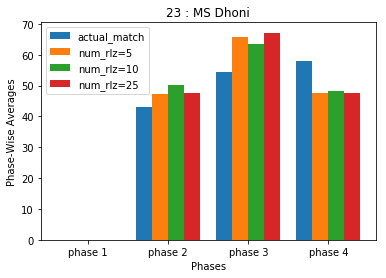

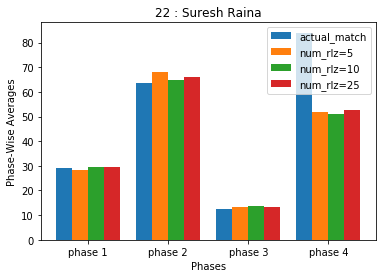

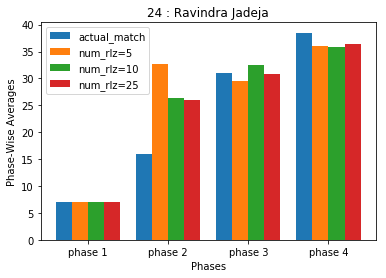

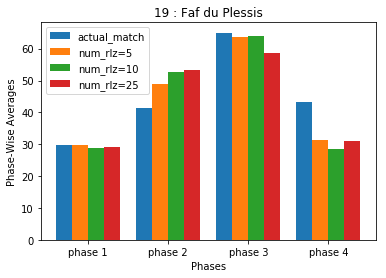

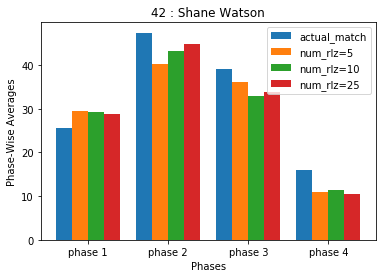

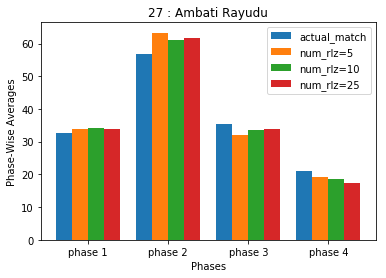

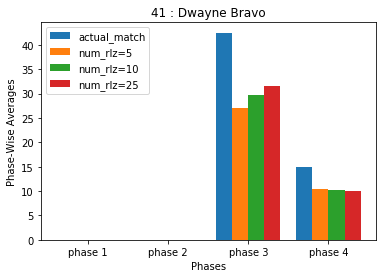

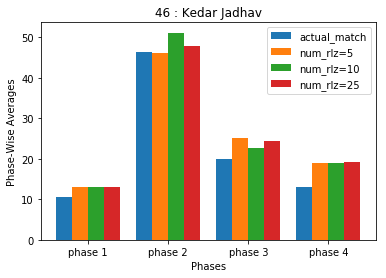

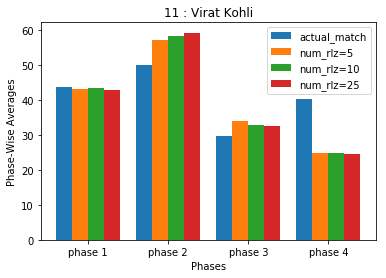

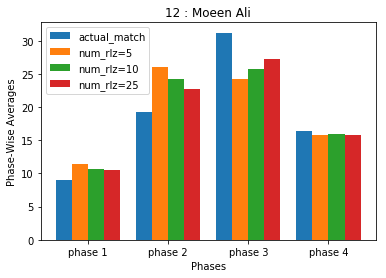

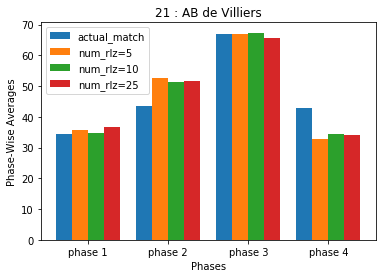

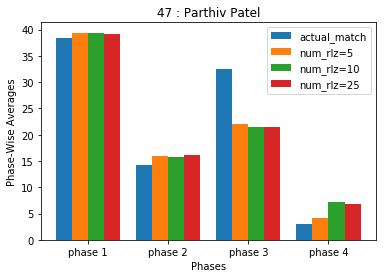

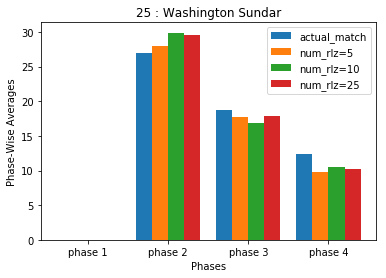

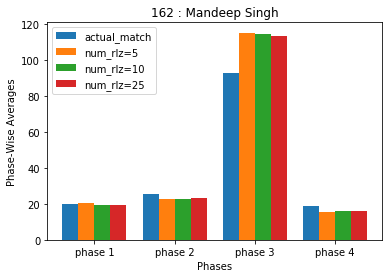

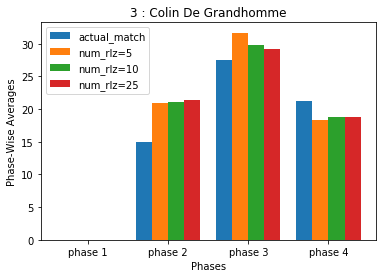

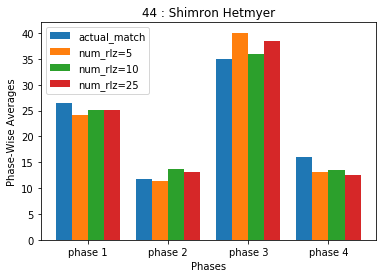

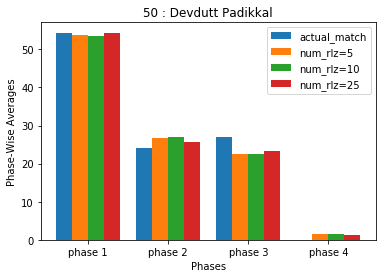

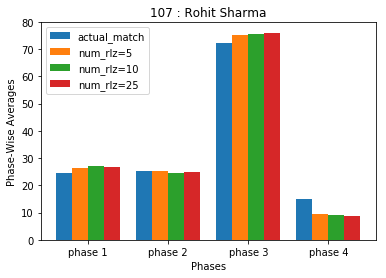

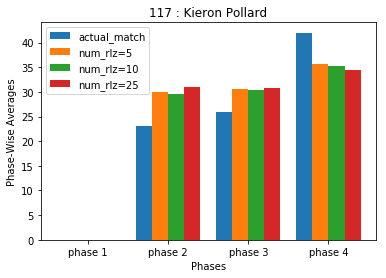

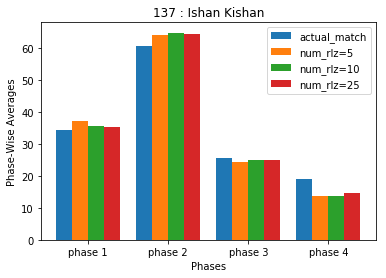

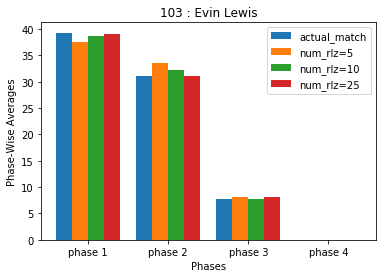

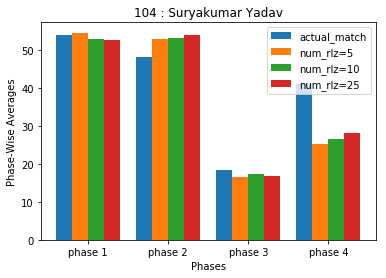

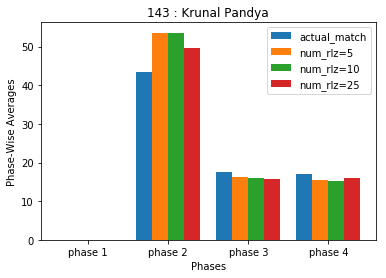

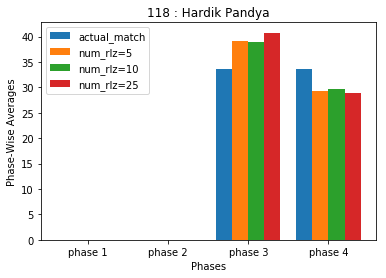

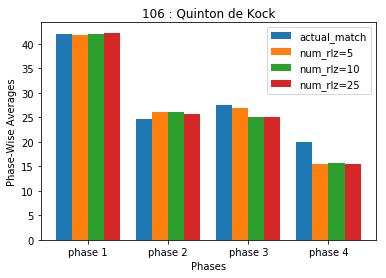

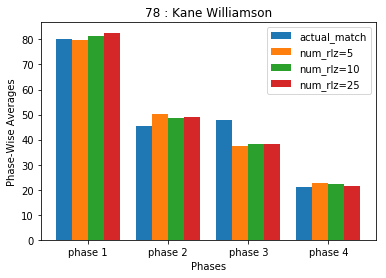

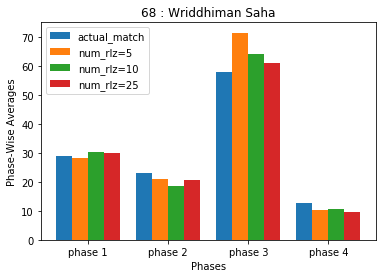

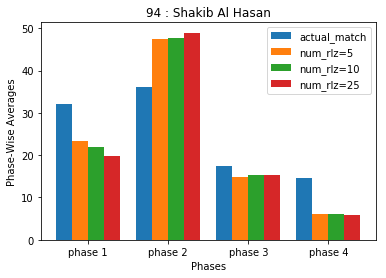

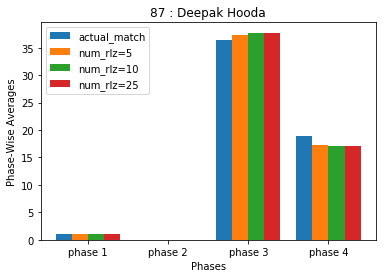

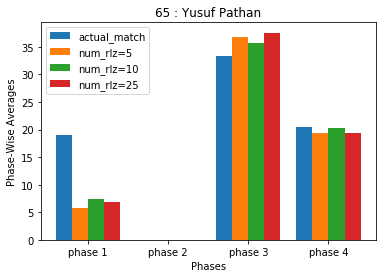

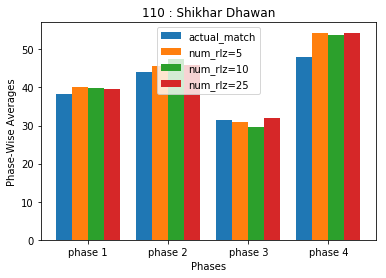

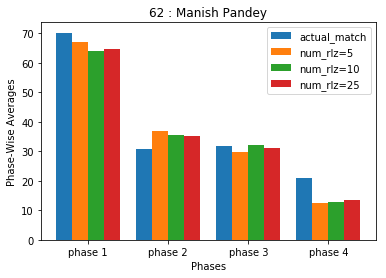

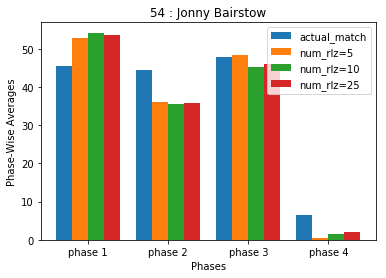

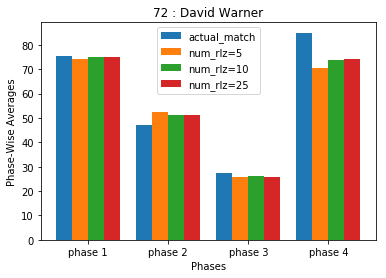

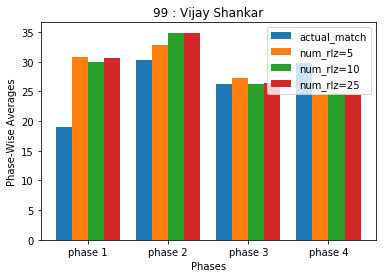

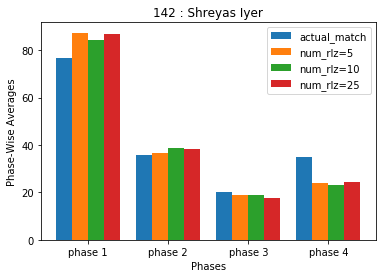

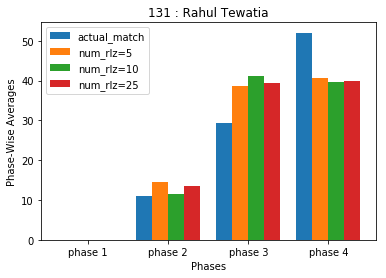

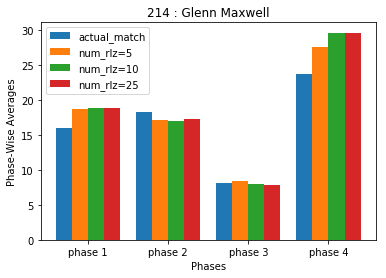

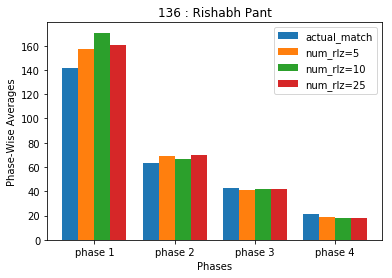

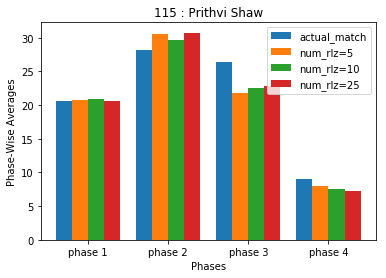

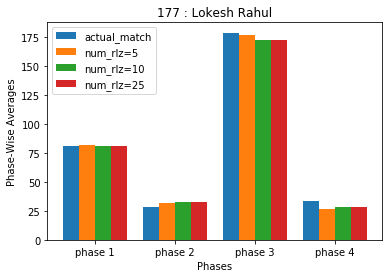

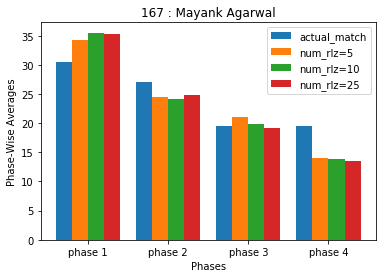

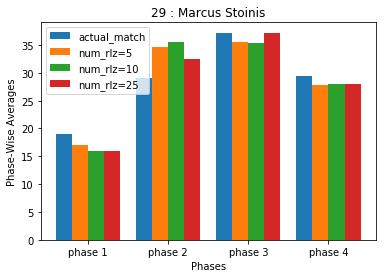

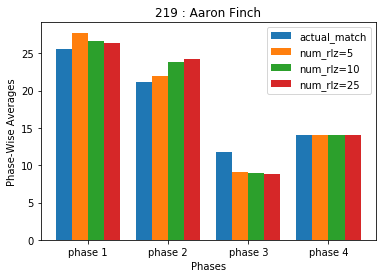

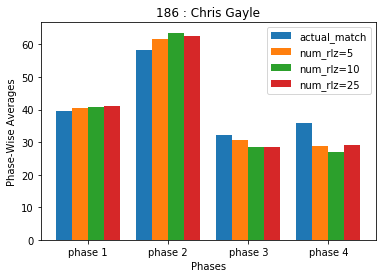

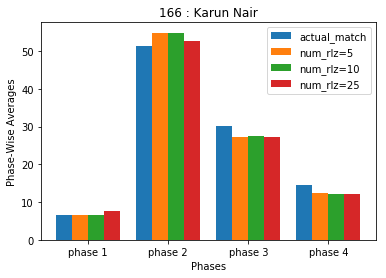

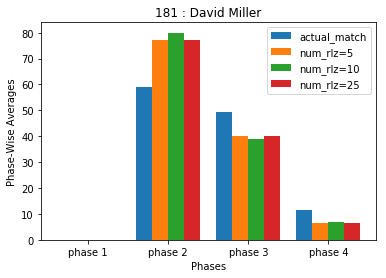

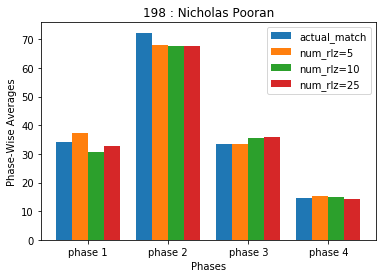

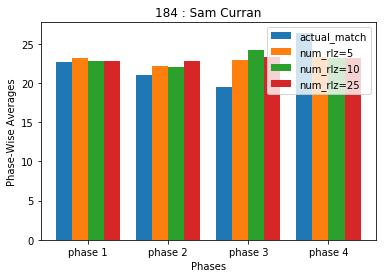

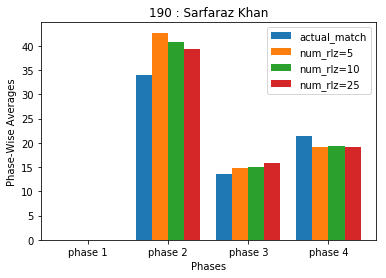

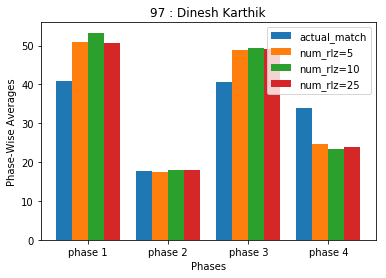

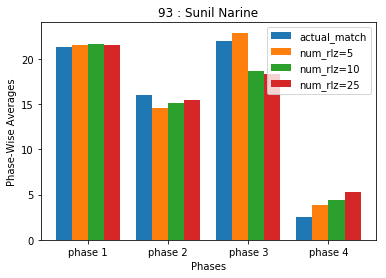

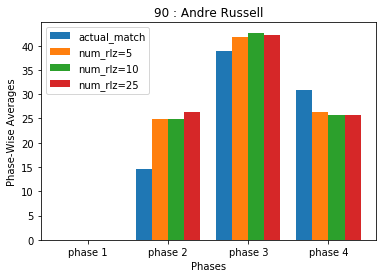

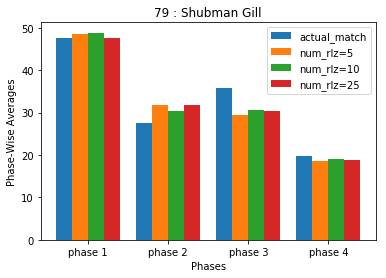

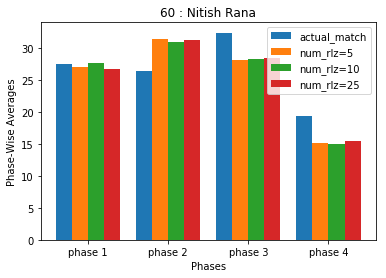

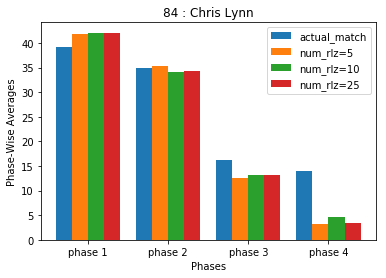

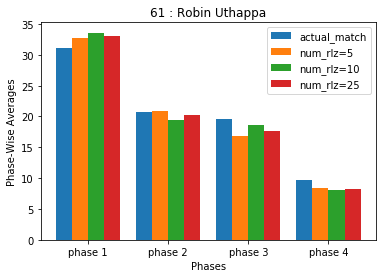

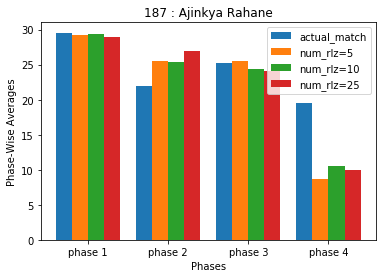

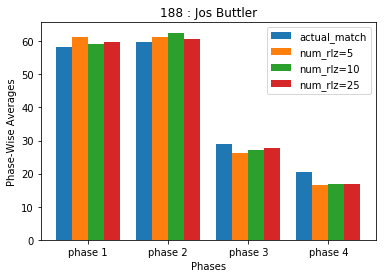

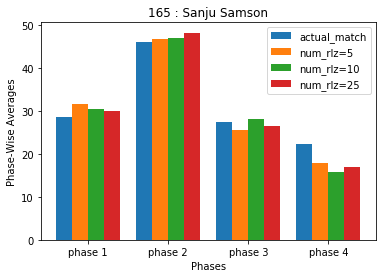

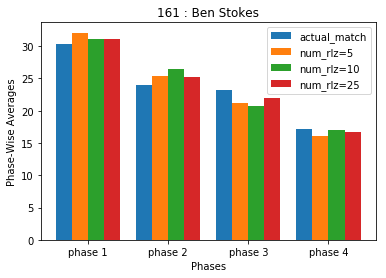

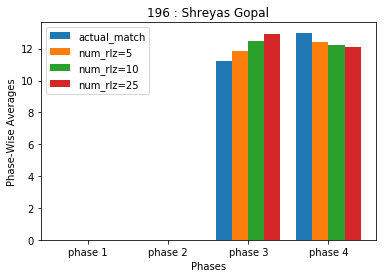

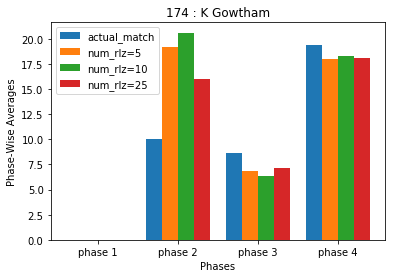

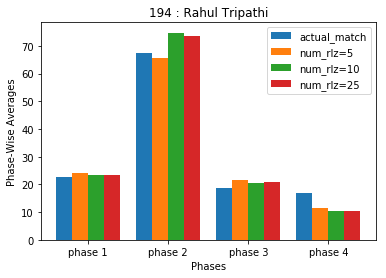

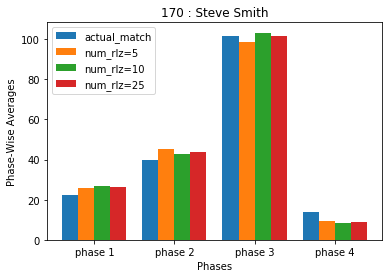

In [539]:
plot_ppwm(ppwa_true, ppwa_pred5, ppwa_pred10, ppwa_pred25, pmp_pred5, pmp_true, metric='avg')

In [39]:
plot_order_averages(ppwa_true, ppwa_pred5, top=15, phase=1)

### Compute Metrics

In [504]:
metric_avg_mae_pred5, metric_avg_mse_pred5, metric_avg_mae_pred10, metric_avg_mse_pred10, metric_avg_mae_pred25, metric_avg_mse_pred25 = compute_metrics(ppwa_true, ppwa_pred5, ppwa_pred10, ppwa_pred25, PHASES)

In [505]:
print(metric_avg_mae_pred5)
print(metric_avg_mse_pred5)
print(metric_avg_mae_pred10)
print(metric_avg_mse_pred10)
print(metric_avg_mae_pred25)
print(metric_avg_mse_pred25)

{1: 2.2, 2: 4.08, 3: 3.73, 4: 5.26}
{1: 15.92, 2: 31.0, 3: 30.44, 4: 53.6}
{1: 2.4, 2: 4.24, 3: 3.53, 4: 5.31}
{1: 25.39, 2: 31.71, 3: 26.56, 4: 54.53}
{1: 2.22, 2: 3.9, 3: 3.54, 4: 5.25}
{1: 18.3, 2: 27.67, 3: 26.1, 4: 51.3}


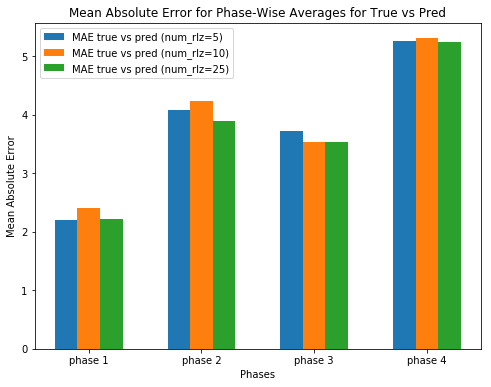

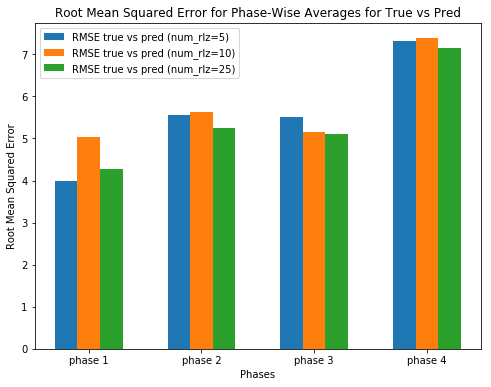

In [506]:
plot_metrics(metric_avg_mae_pred5, metric_avg_mse_pred5, metric_avg_mae_pred10, metric_avg_mse_pred10, metric_avg_mae_pred25, metric_avg_mse_pred25, values='avg')

### Plot phase-wise strike rates

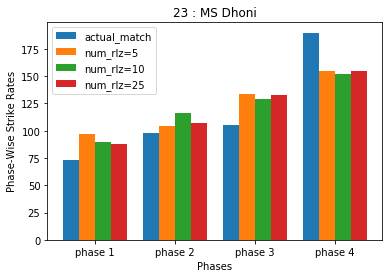

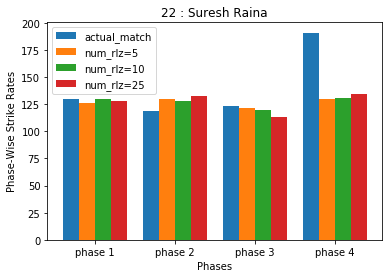

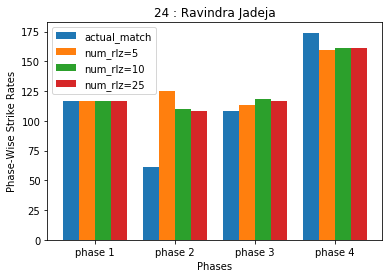

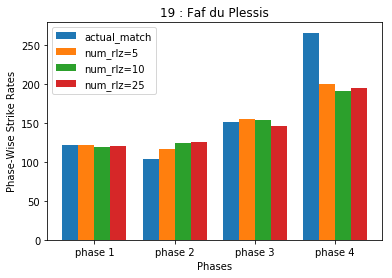

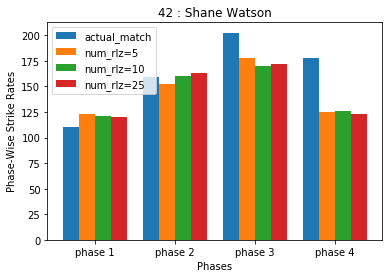

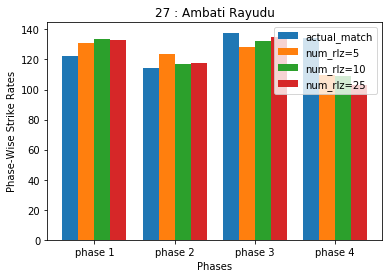

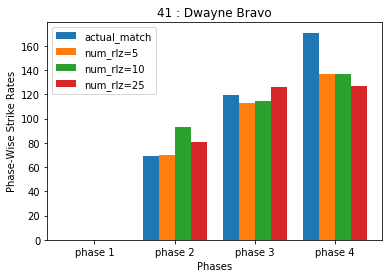

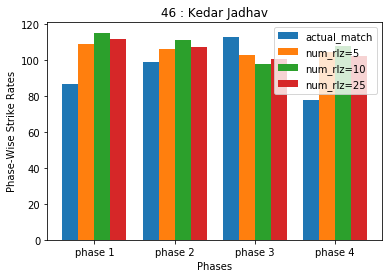

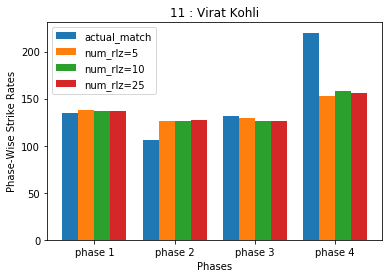

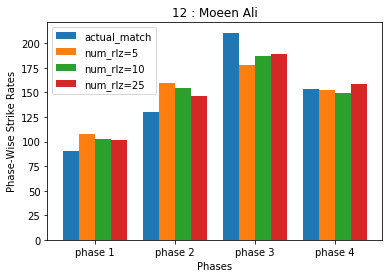

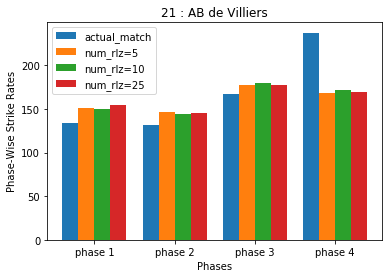

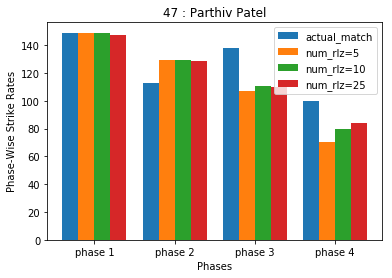

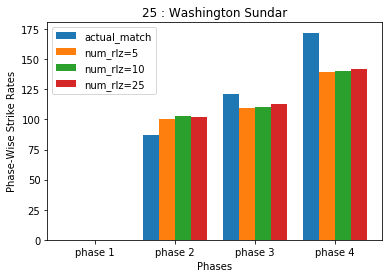

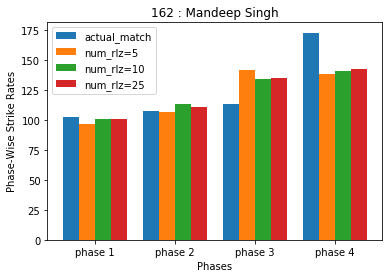

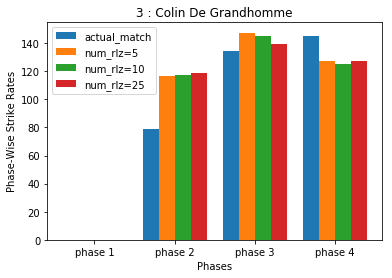

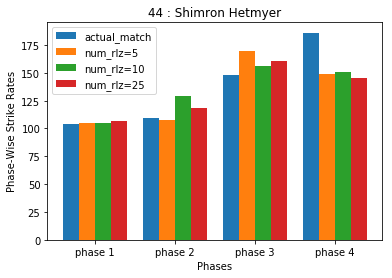

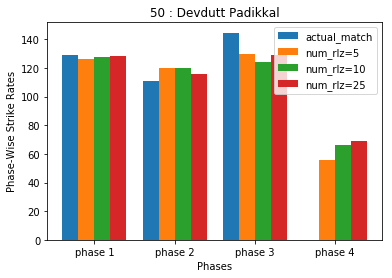

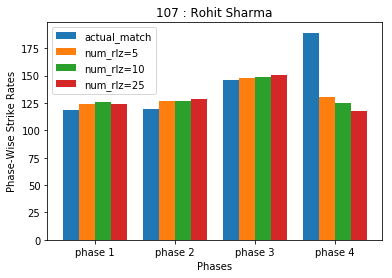

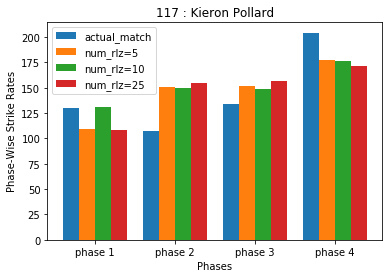

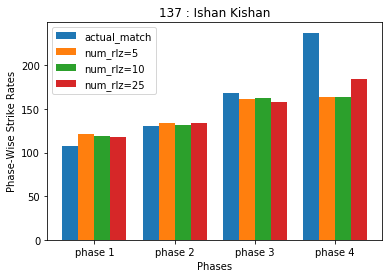

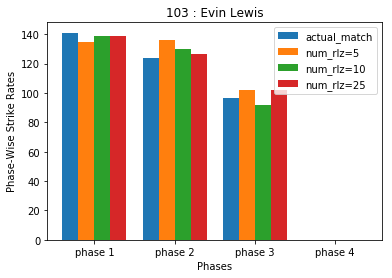

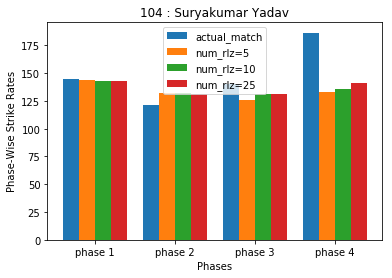

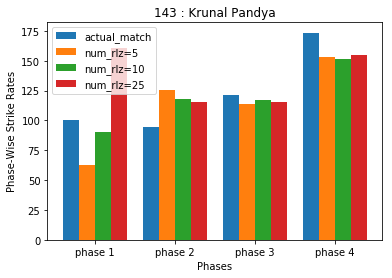

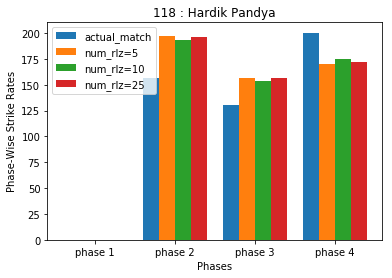

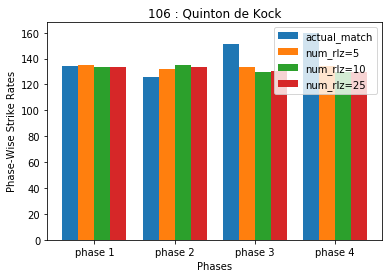

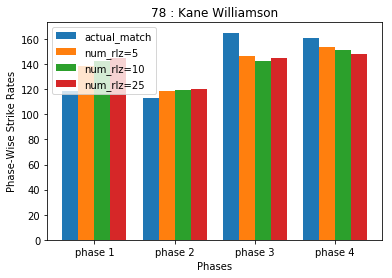

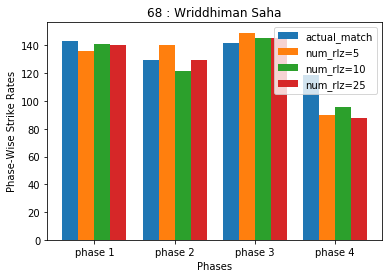

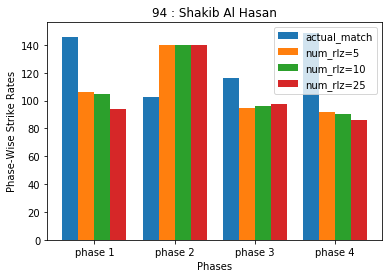

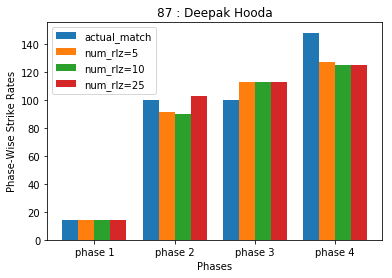

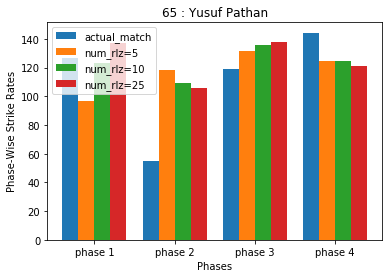

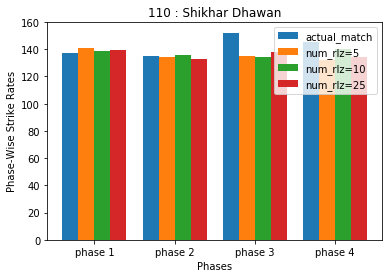

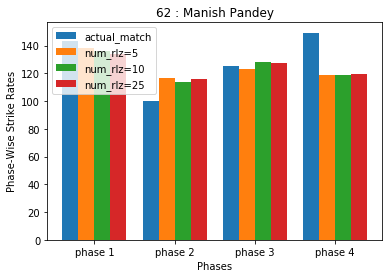

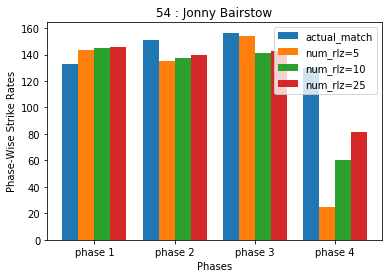

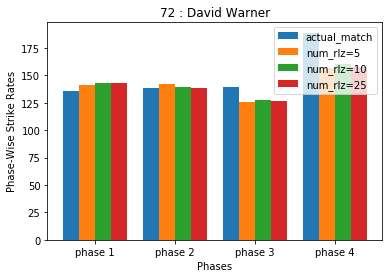

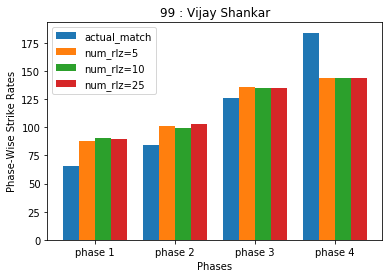

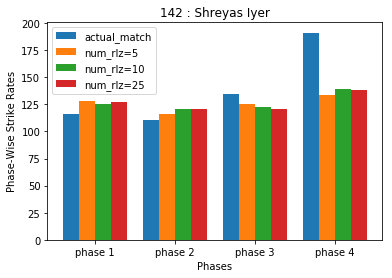

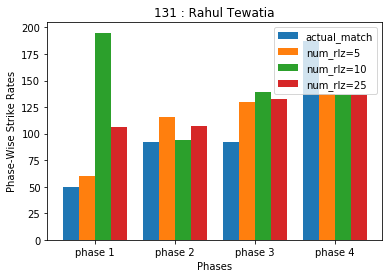

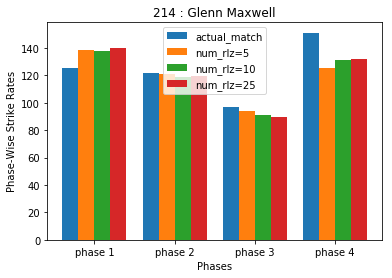

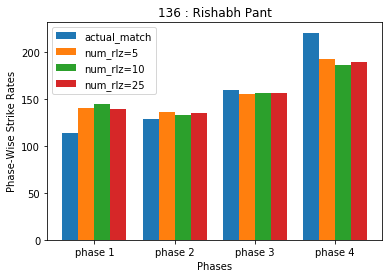

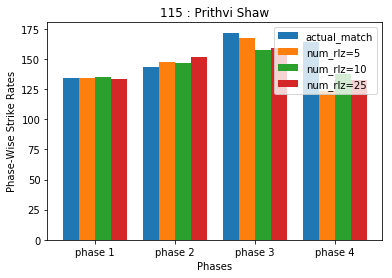

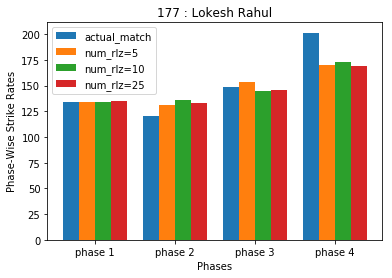

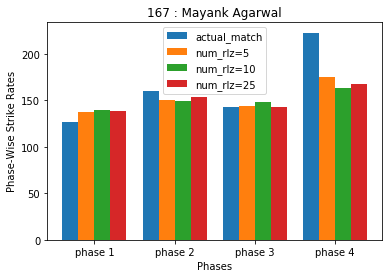

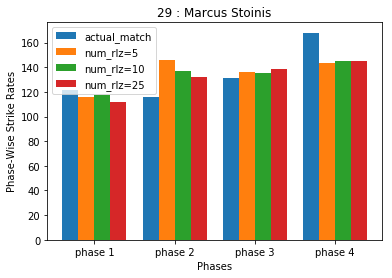

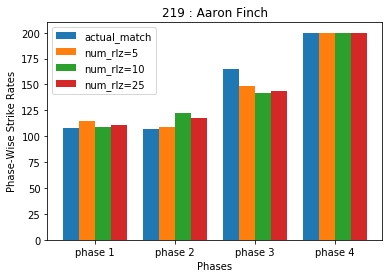

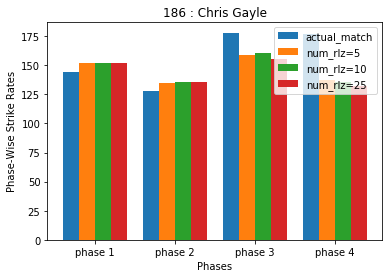

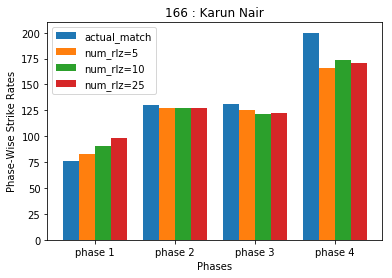

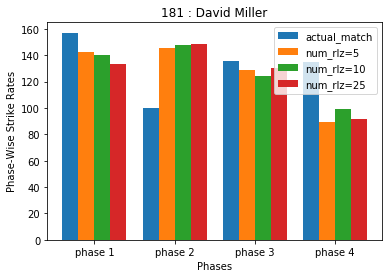

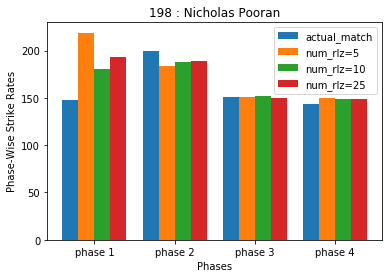

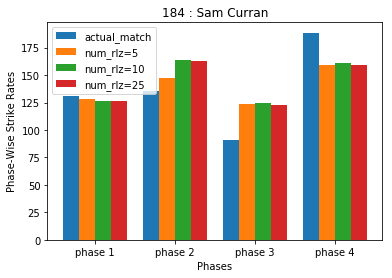

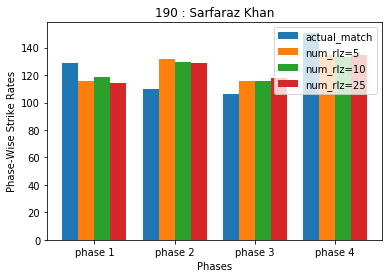

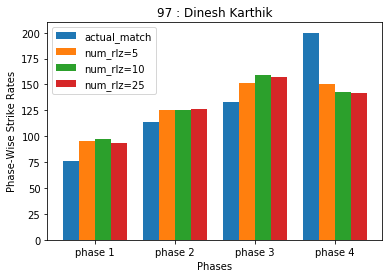

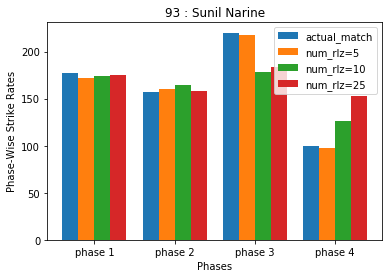

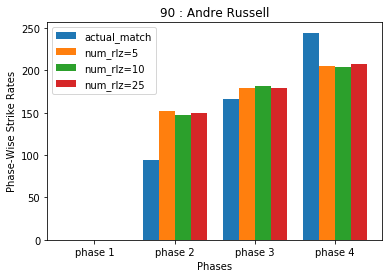

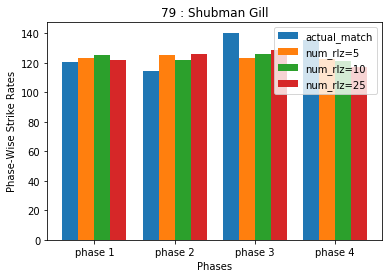

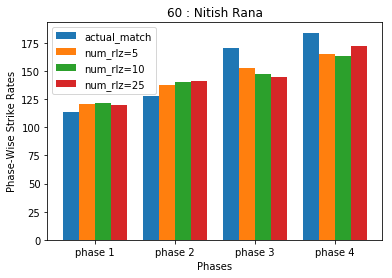

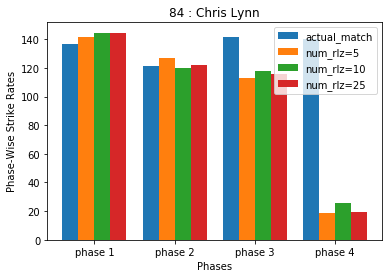

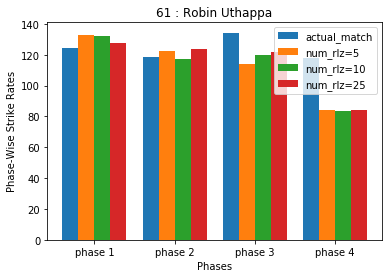

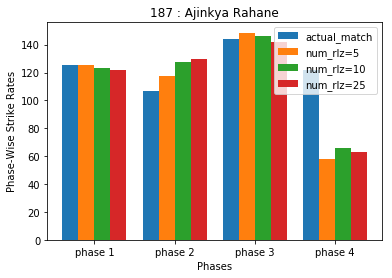

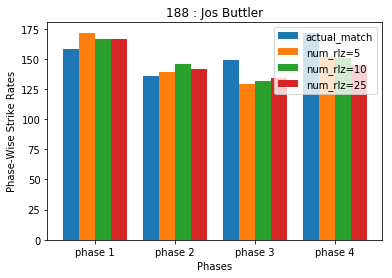

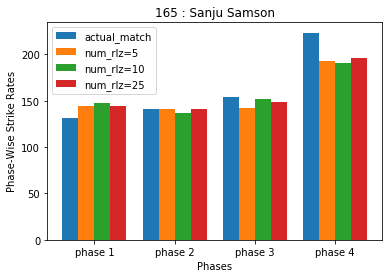

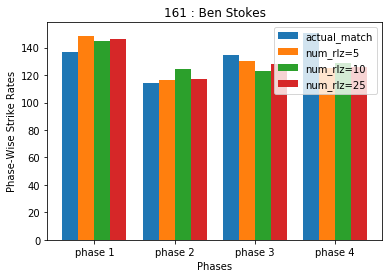

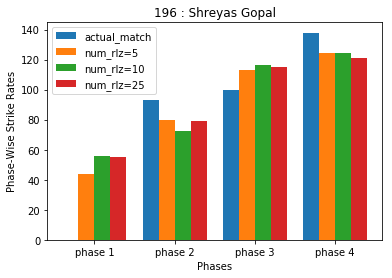

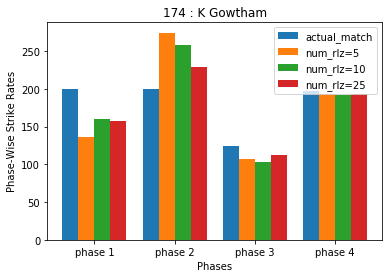

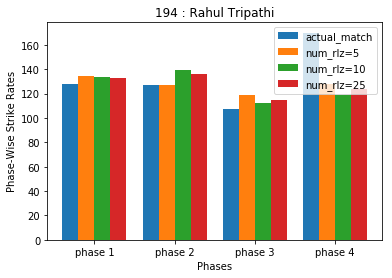

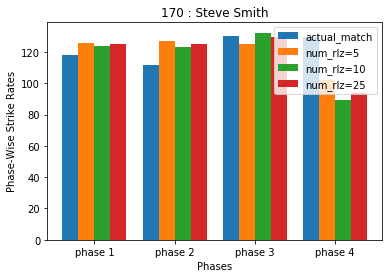

In [507]:
plot_ppwm(ppwsr_true, ppwsr_pred5, ppwsr_pred10, ppwsr_pred25, pmp_pred5, pmp_true, metric='sr')

### Compute Metrics

In [542]:
metric_sr_mae_pred5, metric_sr_mse_pred5, metric_sr_mae_pred10, metric_sr_mse_pred10, metric_sr_mae_pred25, metric_sr_mse_pred25 = compute_metrics(ppwsr_true, ppwsr_pred5, ppwsr_pred10, ppwsr_pred25, PHASES)

In [543]:
print(metric_sr_mae_pred5)
print(metric_sr_mse_pred5)
print(metric_sr_mae_pred10)
print(metric_sr_mse_pred10)
print(metric_sr_mae_pred25)
print(metric_sr_mse_pred25)

{1: 11.61, 2: 15.68, 3: 12.91, 4: 35.12}
{1: 332.63, 2: 522.26, 3: 249.98, 4: 1752.88}
{1: 11.71, 2: 16.01, 3: 13.89, 4: 34.85}
{1: 542.69, 2: 452.5, 3: 287.96, 4: 1668.14}
{1: 12.1, 2: 14.65, 3: 13.39, 4: 35.39}
{1: 366.58, 2: 395.65, 3: 265.02, 4: 1694.35}


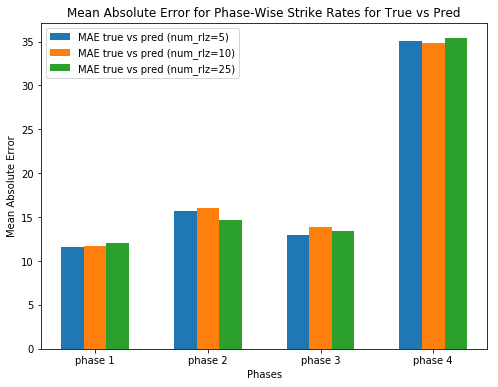

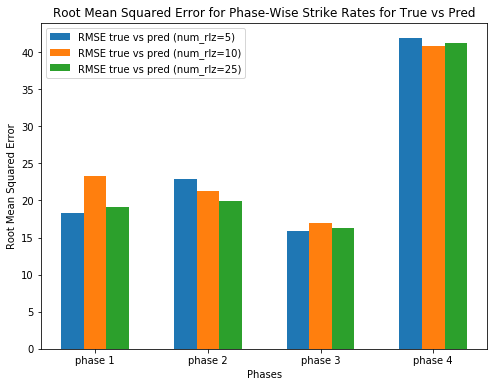

In [544]:
plot_metrics(metric_sr_mae_pred5, metric_sr_mse_pred5, metric_sr_mae_pred10, metric_sr_mse_pred10, metric_sr_mae_pred25, metric_sr_mse_pred25, values='sr')

In [40]:
plot_order_strike_rates(ppwsr_true, ppwsr_pred5, top=15, phase=4)

### Plot of Strike Rate vs Average

In [46]:
def plot_strikerate_vs_average(true, pred):
    '''
    Helper function to generate strike rates vs average plot
    '''
    df = true
    df2 = pred

    df = df.replace(to_replace='-', value=0)
    col_names = df.columns
    df = df.rename(columns={col_names[0]: 'Phase 1 Avg', col_names[1]: 'Phase 2 Avg', col_names[2]: 'Phase 3 Avg', col_names[3]: 'Phase 4 Avg'})
    df = df.astype(float)
    pla_names = list(PID_TO_PNAME(df.index).values())
    pla_names = [ele.split()[-1] for ele in pla_names]
    df['Players'] = pla_names

    df2 = df2.replace(to_replace='-', value=0)
    df2 = df2.rename(columns={col_names[0]: 'Phase 1 SR', col_names[1]: 'Phase 2 SR', col_names[2]: 'Phase 3 SR', col_names[3]: 'Phase 4 SR'})
    df2 = df2.astype(float)

    df3 = pd.concat([df, df2], axis=1)

    remove_players = [46, 25, 3, 44, 50, 103, 68, 94, 166, 184, 190, 196, 41, 162, 143, 68, 94, 99, 194, 187, 174, 170, \
                      60, 84, 61, 65, 219, 167, 54, 47, 137, 106, 161, 29, 214, 19, 186, 79, 115, 165]
    df3 = df3.drop(remove_players)
    
    fig = px.scatter(df3, x="Phase 4 SR", y="Phase 4 Avg", text='Players', title='Predicted : Phase 4')

    def improve_text_position(x):
        """ it is more efficient if the x values are sorted """
        positions = ['top center', 'bottom center']  # you can add more: left center ...
        return [positions[i % len(positions)] for i in range(len(x))]

    fig.update_traces(textposition=improve_text_position(df3['Phase 1 SR']))
    fig.show()

In [47]:
# plot_strikerate_vs_average(ppwa_true, ppwsr_true)
plot_strikerate_vs_average(ppwa_pred5, ppwsr_pred5)

### Experiment : Players who have played a very few matches

In [342]:
# Team CSK
CSK_pids = [41, 46]

# Team RCB
RCB_pids = [12, 47, 25, 3, 44, 50]

# Team MI
MI_pids = [103]

# Team SRH
SRH_pids = [68, 94, 87, 65, 54]

# Team DC
DC_pids = [131]

# Team PBKS
PBKS_pids = [219, 166, 181, 198, 184, 190]

# Team KKR
KKR_pids = []

# Team RR
RR_pids = [196, 174]

OVERALL_pids = CSK_pids + RCB_pids + MI_pids + SRH_pids + DC_pids + PBKS_pids + KKR_pids + RR_pids

### True results

In [332]:
ppwa_true_exp, ppwsr_true_exp, ppwr_true_exp, ppwd_true_exp, pmp_true_exp, nem_exp = compute_actual_phase_wise_averages_strikerates(MATCHES, OVERALL_pids)

100%|████████████████████████████████████████████████████████████| 180/180 [03:34<00:00,  1.19s/it]


### Pred with num_rlz=5

In [333]:
ppwa_pred5_exp, ppwsr_pred5_exp, ppwr_pred5_exp, ppwd_pred5_exp, pmp_pred5_exp = compute_pred_phase_wise_averages_strikerates(MATCHES, OVERALL_pids, 5)

100%|████████████████████████████████████████████████████████████| 180/180 [16:44<00:00,  5.58s/it]


### Pred with num_rlz=10

In [334]:
ppwa_pred10_exp, ppwsr_pred5_exp, ppwr_pred10_exp, ppwd_pred10_exp, pmp_pred10_exp = compute_pred_phase_wise_averages_strikerates(MATCHES, OVERALL_pids, 10)

100%|████████████████████████████████████████████████████████████| 180/180 [32:01<00:00, 10.68s/it]


### Pred with num_rlz=25

In [335]:
ppwa_pred25_exp, ppwsr_pred25_exp, ppwr_pred25_exp, ppwd_pred25_exp, pmp_pred25_exp = compute_pred_phase_wise_averages_strikerates(MATCHES, OVERALL_pids, 25)

100%|██████████████████████████████████████████████████████████| 180/180 [1:09:59<00:00, 23.33s/it]


### Compute metrics

In [336]:
metric_avg_mae_pred5_exp, metric_avg_mse_pred5_exp, metric_avg_mae_pred10_exp, metric_avg_mse_pred10_exp, metric_avg_mae_pred25_exp, metric_avg_mse_pred25_exp = compute_metrics(ppwa_true_exp, ppwa_pred5_exp, ppwa_pred10_exp, ppwa_pred25_exp, PHASES)

In [338]:
metric_sr_mae_pred5_exp, metric_sr_mse_pred5_exp, metric_sr_mae_pred10_exp, metric_sr_mse_pred10_exp, metric_sr_mae_pred25_exp, metric_sr_mse_pred25_exp = compute_metrics(ppwsr_true_exp, ppwsr_pred5_exp, ppwsr_pred5_exp, ppwsr_pred25_exp, PHASES)

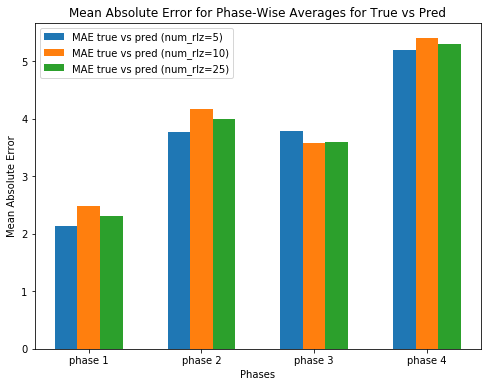

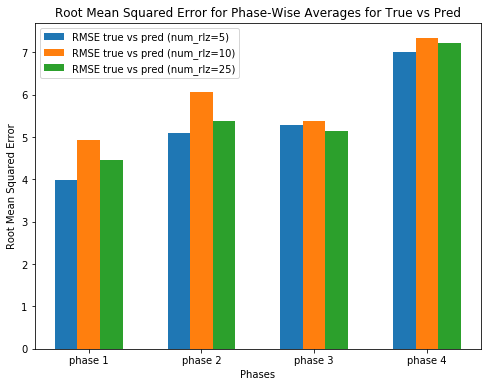

In [339]:
plot_metrics(metric_avg_mae_pred5_exp, metric_avg_mse_pred5_exp, metric_avg_mae_pred10_exp, metric_avg_mse_pred10_exp, metric_avg_mae_pred25_exp, metric_avg_mse_pred25_exp, values='avg')

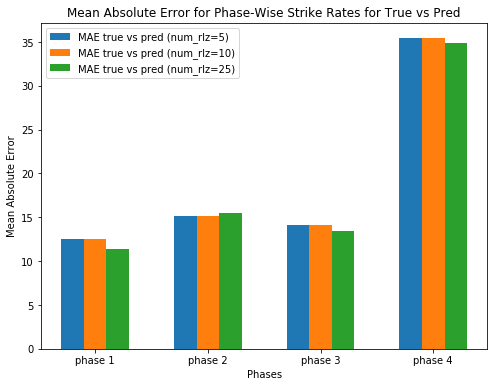

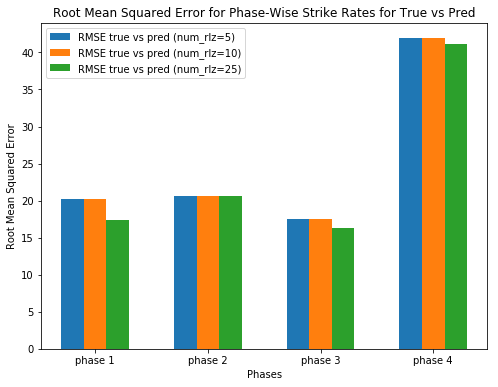

In [340]:
plot_metrics(metric_sr_mae_pred5_exp, metric_sr_mse_pred5_exp, metric_sr_mae_pred10_exp, metric_sr_mse_pred10_exp, metric_sr_mae_pred25_exp, metric_sr_mse_pred25_exp, values='sr')

## Testing on SMAT

### Set matches here

In [69]:
MATCHES_SMAT = range(1718, 2109)

### Define PHASES

In [70]:
PHASES = {1: (1,36),
          2: (37,66),
          3: (67,96),
          4: (97,120)
         }

### SMAT Players

In [71]:
TN_player_ids = [2097, 2334, 2332, 99, 2152, 2333, 97, 43]

Maha_player_ids = [194, 1, 46, 1910, 86, 1927]

Kar_player_ids = [166, 50, 2237, 2238, 226, 2236, 232, 196, 174]

Bar_player_ids = [2468, 143, 87, 1895, 1893, 1903]

OVERALL_SMAT_pids = TN_player_ids + Maha_player_ids + Kar_player_ids + Bar_player_ids

len(PID_TO_PNAME(OVERALL_SMAT_pids).keys())

29

### True results

In [78]:
res = compute_actual_phase_wise_averages_strikerates(MATCHES_SMAT, OVERALL_SMAT_pids)
ppwa_true_smat, ppwsr_true_smat, ppwr_true_smat, ppwd_true_smat, pmp_smat, num_error_matches = res[0], res[1], res[2], res[3], res[4], res[5]

100%|████████████████████████████████████████████████████████████| 391/391 [05:37<00:00,  1.16it/s]


### Predictions with num_rlz=1

In [79]:
ppwa_pred1_smat, ppwsr_pred1_smat, ppwr_pred1_smat, ppwd_pred1_smat, pmp_pred1_smat = compute_pred_phase_wise_averages_strikerates(MATCHES_SMAT, OVERALL_SMAT_pids, 1)

100%|████████████████████████████████████████████████████████████| 391/391 [06:48<00:00,  1.04s/it]


### Predictions with num_rlz=5

In [80]:
ppwa_pred5_smat, ppwsr_pred5_smat, ppwr_pred5_smat, ppwd_pred5_smat, pmp_pred5_smat = compute_pred_phase_wise_averages_strikerates(MATCHES_SMAT, OVERALL_SMAT_pids, 5)

100%|████████████████████████████████████████████████████████████| 391/391 [08:38<00:00,  1.33s/it]


### Predictions with num_rlz=10

In [81]:
ppwa_pred10_smat, ppwsr_pred10_smat, ppwr_pred10_smat, ppwd_pred10_smat, pmp_pred10_smat = compute_pred_phase_wise_averages_strikerates(MATCHES_SMAT, OVERALL_SMAT_pids, 10)

100%|████████████████████████████████████████████████████████████| 391/391 [15:17<00:00,  2.35s/it]


### Predictions with num_rlz=25

In [82]:
ppwa_pred25_smat, ppwsr_pred25_smat, ppwr_pred25_smat, ppwd_pred25_smat, pmp_pred25_smat = compute_pred_phase_wise_averages_strikerates(MATCHES_SMAT, OVERALL_SMAT_pids, 25)

100%|████████████████████████████████████████████████████████████| 391/391 [25:44<00:00,  3.95s/it]


### Plot phase-wise averages

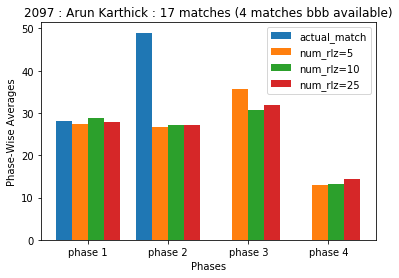

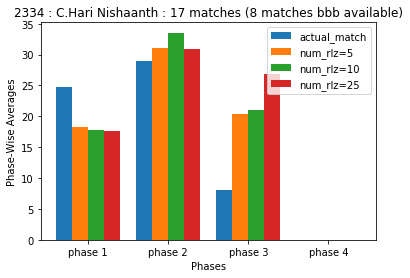

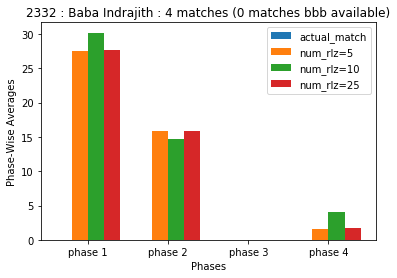

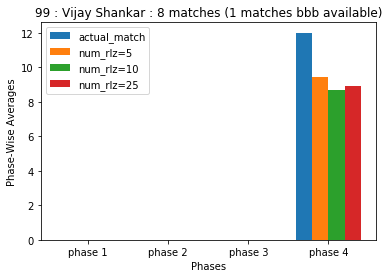

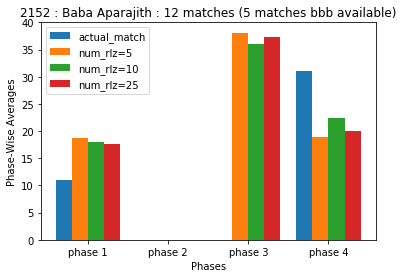

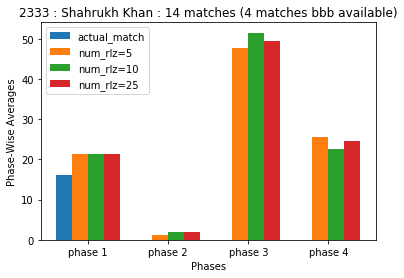

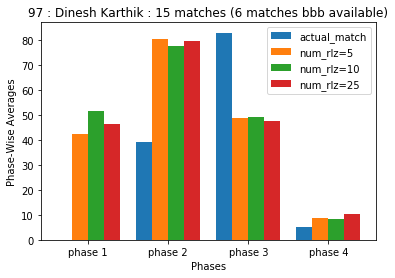

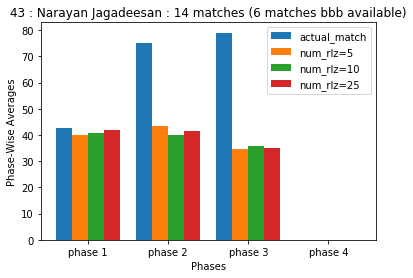

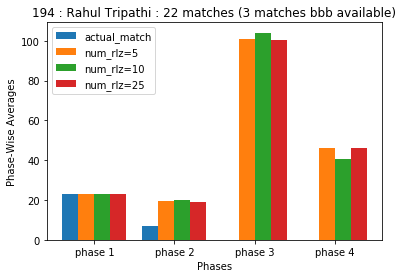

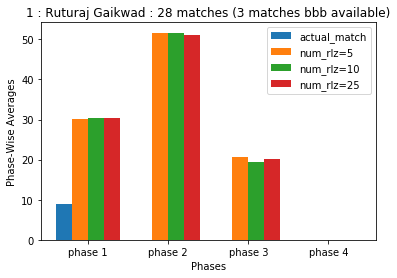

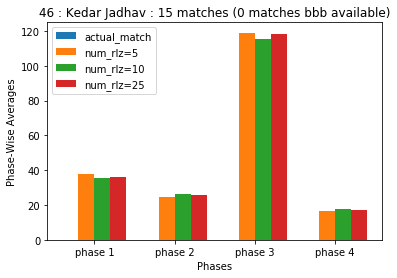

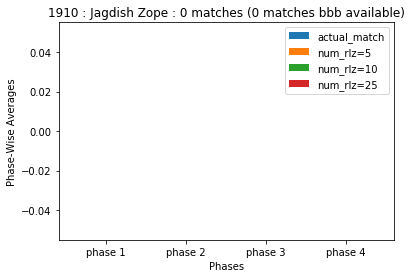

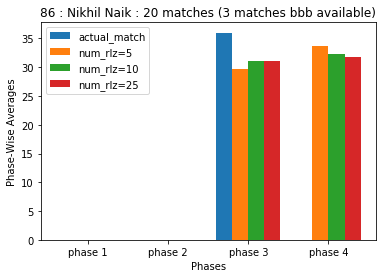

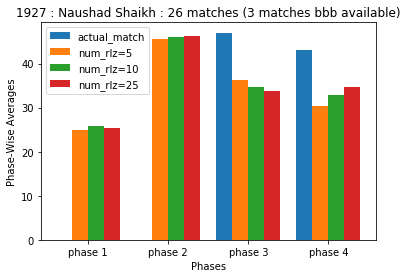

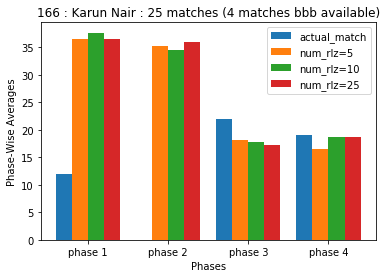

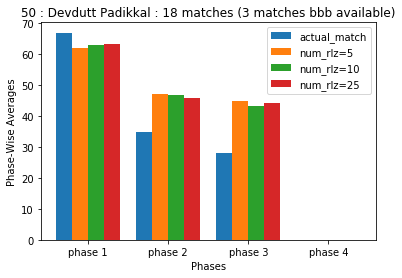

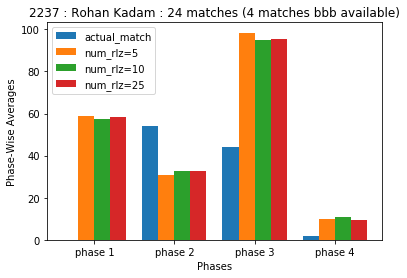

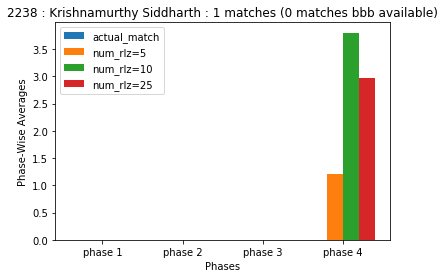

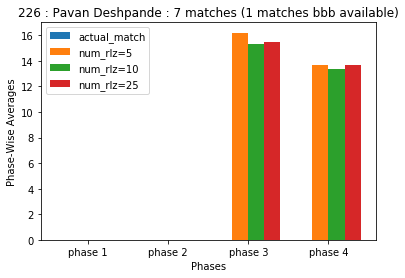

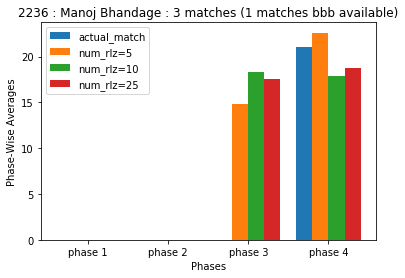

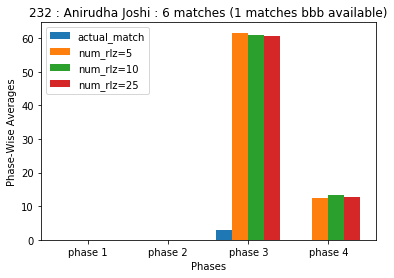

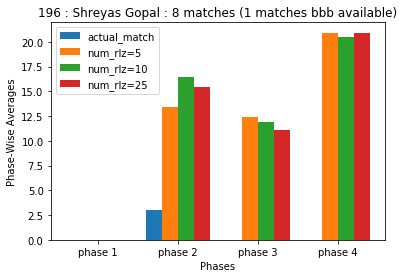

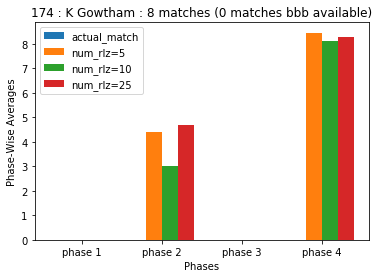

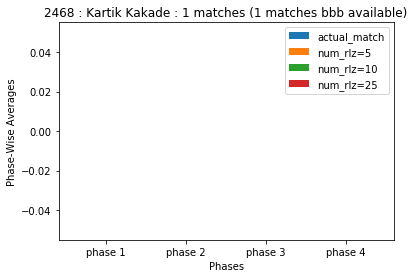

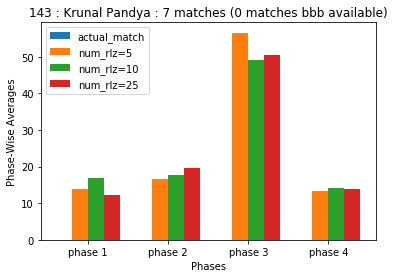

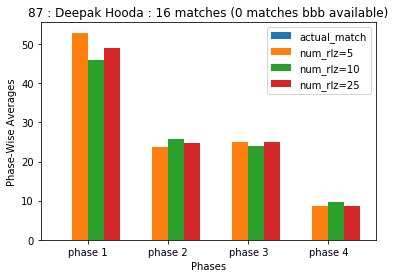

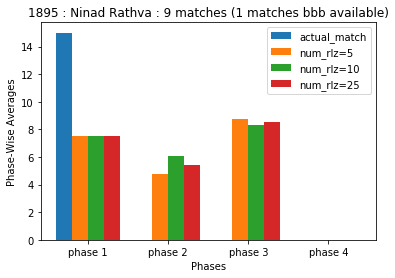

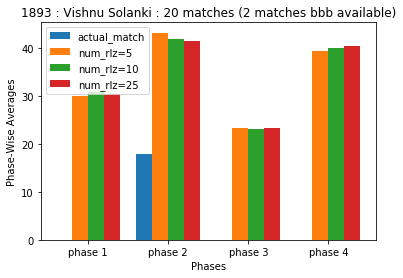

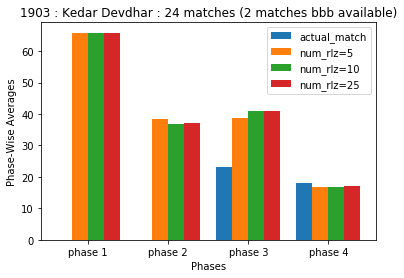

In [83]:
plot_ppwa(ppwa_true_smat, ppwa_pred5_smat, ppwa_pred10_smat, ppwa_pred25_smat, pmp_pred1_smat, pmp_smat)

### Plot phase-wise strike rates

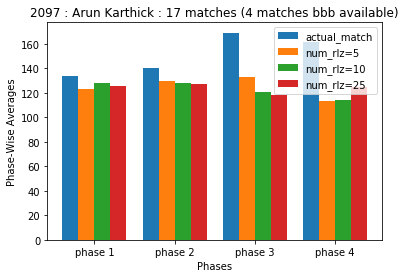

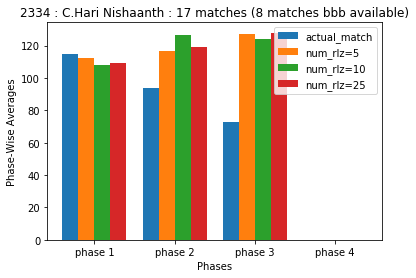

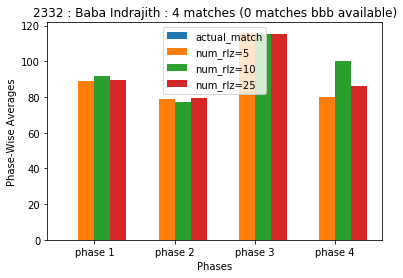

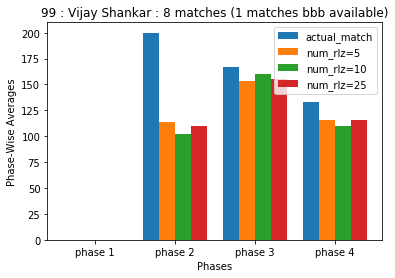

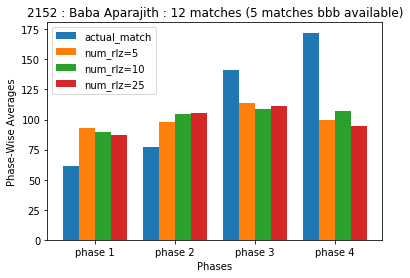

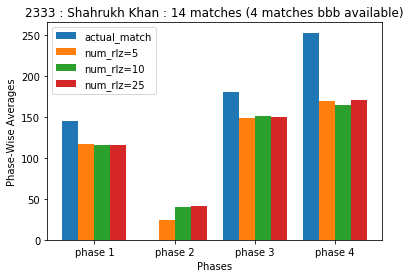

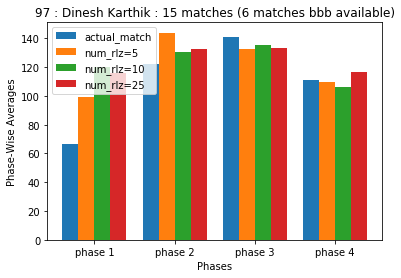

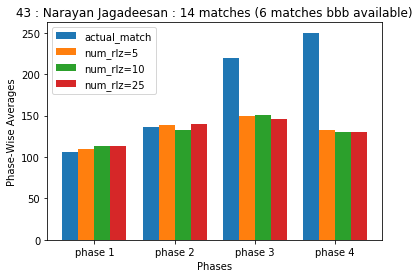

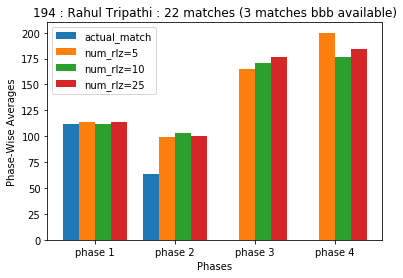

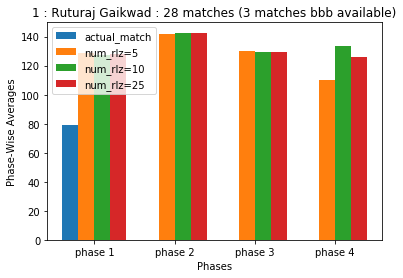

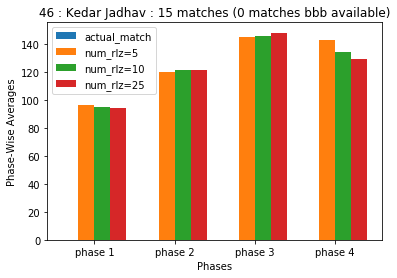

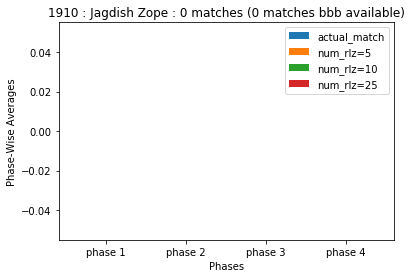

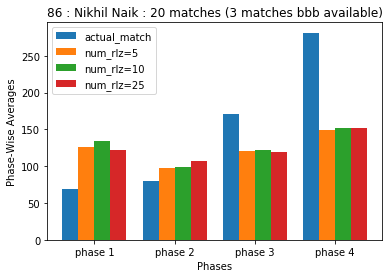

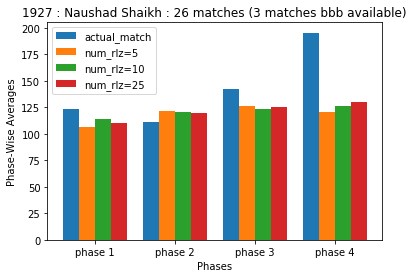

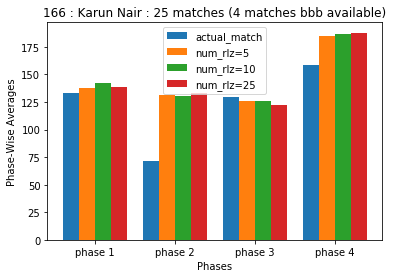

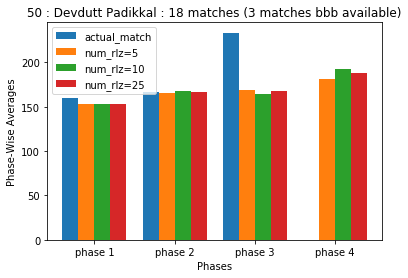

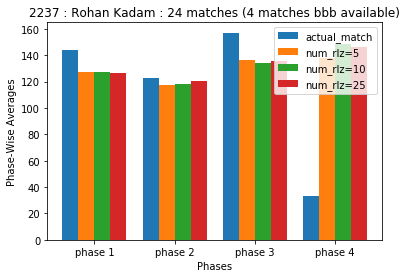

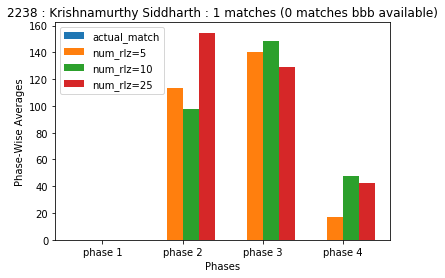

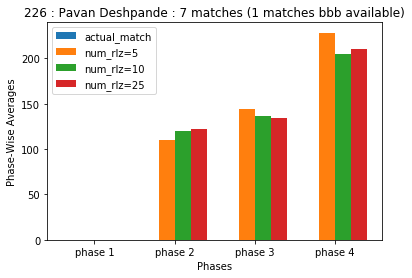

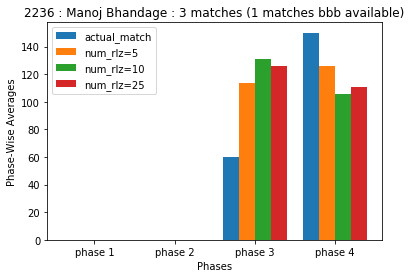

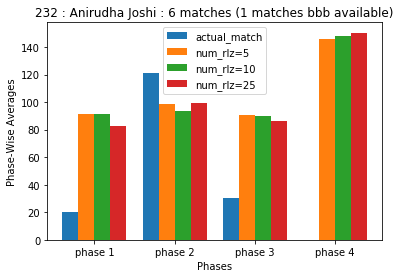

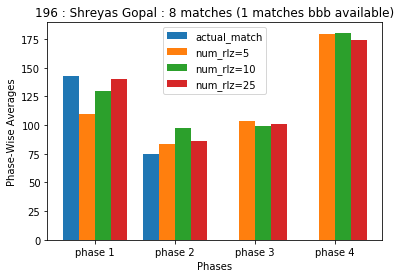

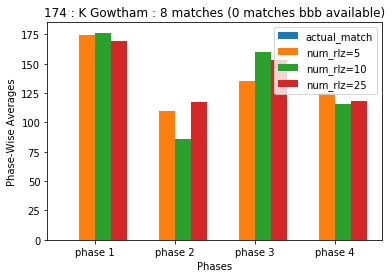

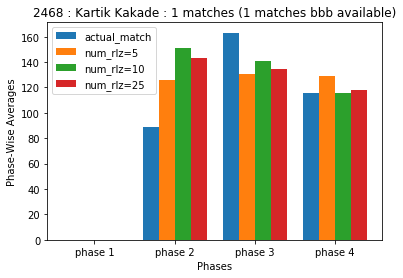

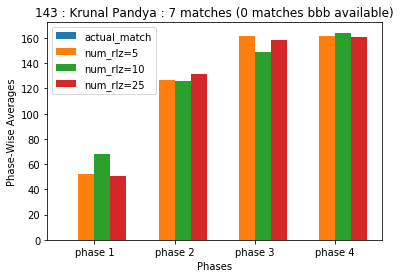

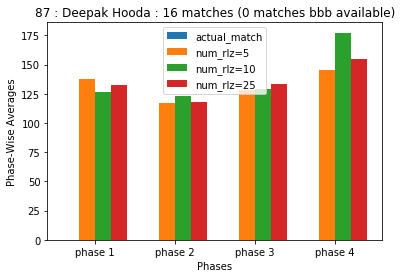

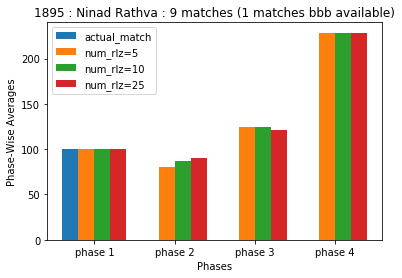

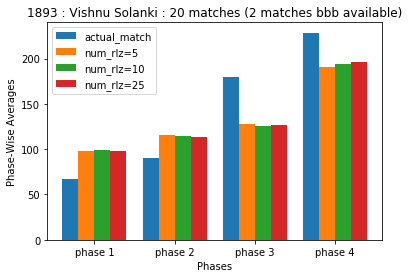

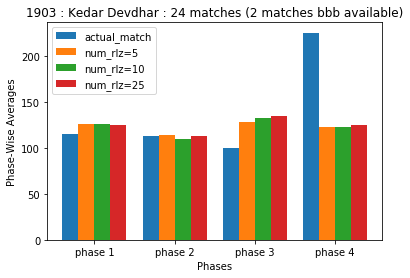

In [84]:
plot_ppwa(ppwsr_true_smat, ppwsr_pred5_smat, ppwsr_pred10_smat, ppwsr_pred25_smat, pmp_pred1_smat, pmp_smat)